# Business Understanding

## Problem Statement
Traffic accidents in Chicago causes 1 death in every 3 days, and 5 serious injuries in everyday.

Only between 2010-2014, 554 people had been killed and 9480 had been seriously injured on those accidents.

## End Goal
The end goal is to 
- identify where we can *reduce* risks, and/or *educate* the public better on potential risks 
- develop a model *to predict* the probability of future accidents and fatal/total injuries. 

<a id='top'></a>
# Exploratory Data Analysis Framework 

We should evaluate the quality of data at our disposal and demonstrate which factors have the highest impact on the model decisions.

- [Data Description](#data_description)
- [Data Quality Assessment](#data_quality)
- [Overview of Data Distributions](#data_distributions)
- [Analysis of Geolocation, Time Series and Categorical Data](#data_different)
- [Correlation Analysis](#data_correlation)

In [1]:
import timeit
start_time = timeit.default_timer()  #timestamp to calculate total runtime

import pandas as pd
import numpy as np

import researchpy as rp
import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt

import itertools
import scipy.stats as ss

import folium
from folium import plugins

%matplotlib inline
pd.set_option('display.max_columns', None)  # prevent output trancation
sns.set()  # change plot styling from Matlab's 90s feel to today's Seaborn.

In [2]:
# File Directories
path_crashes = 'data/crashes.sample2020.csv'
path_vehicles = 'data/vehicles.sample.csv'
path_people = 'data/people.sample.csv'

# Columns that will be read as categorical
# The fromkeys() method returns a dictionary with the specified keys and the specified value
categoricals_crashes = dict.fromkeys(
    [5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 35],
    'category')
categoricals_vehicles = dict.fromkeys([5, 9, 10, 11, 13, 14, 15, 16, 17, 38],
                                      'category')
categoricals_people = dict.fromkeys(
    [7, 8, 10, 12, 13, 14, 15, 17, 21, 22, 23, 27], 'category')

# Import samples
crashes = pd.read_csv(
    path_crashes,
    parse_dates=["CRASH_DATE", "CRASH_DATE_EST_I", "DATE_POLICE_NOTIFIED"],
    low_memory=False,
    dtype=categoricals_crashes)
vehicles = pd.read_csv(path_vehicles,
                       parse_dates=["CRASH_DATE"],
                       low_memory=False,
                       dtype=categoricals_vehicles)
people = pd.read_csv(path_people,
                     parse_dates=["CRASH_DATE"],
                     low_memory=False,
                     dtype=categoricals_people)

<a id='data_description'></a>
## Data Description

*[Back to Top](#top)*

Number of observations and features in samples.

In [3]:
# dimensions of sample datasets
print(crashes.shape)
print(vehicles.shape)
print(people.shape)

(33408, 49)
(75673, 72)
(82049, 30)


### Data Information

Data Dictionaries and important explanations of datasets provided by City of Chicago.

- [`Crashes`](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if)

> *\"...If any new or updated information on a crash is received, the reporting officer may amend the crash report at a later time.\"*

> *\"As per Illinois statute, only crashes with a property damage value of **$1,500 or more or involving bodily injury to any person(s)** and ..., are considered reportable crashes. However, CPD records every reported traffic crash event, regardless of the statute of limitations, ..."*

---

- [`Vehicles`](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Vehicles/68nd-jvt3)

> *\"Each mode of transportation involved in a crash is a **“unit”** and get one entry here. Each vehicle, each pedestrian, each motorcyclist, and each bicyclist **is considered an independent unit** that can have a trajectory separate from the other units.\"*

> *\"Vehicle information can be linked back to Crash data using the **CRASH_RECORD_ID** field.\"* 

> *\"Data for occupants who do not make up an independent unit, typically **drivers and passengers**, are available in the **People** table.\"*

> *\"Since this dataset is a combination of vehicles, pedestrians, and pedal cyclists not all columns are applicable to each record. Look at the **Unit Type** field to determine what additional data may be available for that record.\"*

---
 
- [`People`](https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d)

> *\"Each record corresponds to **an occupant in a vehicle** listed in the Crash dataset. Some people involved in a crash **may not** have been an occupant in a motor vehicle, but may have been a pedestrian, bicyclist, or using another non-motor vehicle mode of transportation.\"*

> *\"Fatalities that occur after the initial reports are typically updated in these records **up to 30 days** after the date of the crash.\"*

> *\"Person data can be linked with the Crash and Vehicle dataset using the **CRASH_RECORD_ID** field.\"* 

> *\"A vehicle can have multiple occupants and hence have a **one to many** relationship between Vehicle and Person dataset. However, a pedestrian is a **“unit”** by itself and have a **one to one** relationship between the Vehicle and Person table.\"*

### First Inspection

#### `crashes`

In [4]:
crashes.head()

CRASH_RECORD_ID     RD_NO  \
0  0211e1f766f3940dfa87375661d25b716655e908c320cc...  JC301403   
1  02e2ed3606a50dda185f5e97c57a45552087d6fbea1c4b...  JB256393   
2  03def753c76d0105940f82e9eaac6f1d87683b7a574c20...  JB246843   
3  14fc616db83000e28d672601062a56d76583c0889a764b...  JB372787   
4  1a9af7862e8471daf453354e6aae4561d0ff4f2f1bfb30...  JB490362   

  CRASH_DATE_EST_I          CRASH_DATE  POSTED_SPEED_LIMIT  \
0              NaN 2019-06-11 08:40:00                  30   
1              NaN 2018-05-09 11:30:00                  25   
2              NaN 2018-05-02 12:50:00                  30   
3              NaN 2018-07-31 11:25:00                  35   
4              NaN 2018-10-25 22:50:00                  30   

  TRAFFIC_CONTROL_DEVICE      DEVICE_CONDITION WEATHER_CONDITION  \
0         TRAFFIC SIGNAL  FUNCTIONING PROPERLY             CLEAR   
1            NO CONTROLS           NO CONTROLS              RAIN   
2            NO CONTROLS           NO CONTROLS             CLEAR   
3         TRAFFIC SIGNAL  FUNCTIONING PROPERLY             CLEAR   
4            NO CONTROLS           NO CONTROLS             CLEAR   

       LIGHTING_CONDITION FIRST_CRASH_TYPE             TRAFFICWAY_TYPE  \
0                DAYLIGHT         REAR END  DIVIDED - W/MEDIAN BARRIER   
1                DAYLIGHT            ANGLE                 NOT DIVIDED   
2                DAYLIGHT     OTHER OBJECT                 PARKING LOT   
3                DAYLIGHT          TURNING                 NOT DIVIDED   
4  DARKNESS, LIGHTED ROAD     FIXED OBJECT                 NOT DIVIDED   

   LANE_CNT           ALIGNMENT ROADWAY_SURFACE_COND ROAD_DEFECT  \
0       NaN  STRAIGHT AND LEVEL                  DRY  NO DEFECTS   
1       2.0  STRAIGHT AND LEVEL                  WET  NO DEFECTS   
2       NaN  STRAIGHT AND LEVEL                  DRY  NO DEFECTS   
3       NaN  STRAIGHT AND LEVEL                  DRY  NO DEFECTS   
4       2.0  STRAIGHT AND LEVEL                  DRY  NO DEFECTS   

                  REPORT_TYPE                        CRASH_TYPE  \
0  NOT ON SCENE (DESK REPORT)            NO INJURY / DRIVE AWAY   
1                    ON SCENE            NO INJURY / DRIVE AWAY   
2                    ON SCENE  INJURY AND / OR TOW DUE TO CRASH   
3                    ON SCENE            NO INJURY / DRIVE AWAY   
4                         NaN  INJURY AND / OR TOW DUE TO CRASH   

  INTERSECTION_RELATED_I NOT_RIGHT_OF_WAY_I HIT_AND_RUN_I         DAMAGE  \
0                      Y                NaN           NaN  $501 - $1,500   
1                    NaN                NaN           NaN    OVER $1,500   
2                    NaN                NaN           NaN    OVER $1,500   
3                    NaN                NaN           NaN    OVER $1,500   
4                    NaN                NaN             Y    OVER $1,500   

  DATE_POLICE_NOTIFIED                 PRIM_CONTRIBUTORY_CAUSE  \
0  2019-06-11 09:05:00                     UNABLE TO DETERMINE   
1  2018-05-09 11:35:00           FAILING TO YIELD RIGHT-OF-WAY   
2  2018-05-02 12:53:00                     UNABLE TO DETERMINE   
3  2018-07-31 11:30:00           FAILING TO YIELD RIGHT-OF-WAY   
4  2018-10-25 23:09:00  FAILING TO REDUCE SPEED TO AVOID CRASH   

          SEC_CONTRIBUTORY_CAUSE  STREET_NO STREET_DIRECTION    STREET_NAME  \
0                 NOT APPLICABLE         50                E  GARFIELD BLVD   
1            UNABLE TO DETERMINE       9511                S  WENTWORTH AVE   
2            UNABLE TO DETERMINE       1320                E        47TH ST   
3  FAILING TO YIELD RIGHT-OF-WAY       8301                S     CICERO AVE   
4                 NOT APPLICABLE       2325                W     ADDISON ST   

   BEAT_OF_OCCURRENCE PHOTOS_TAKEN_I STATEMENTS_TAKEN_I DOORING_I WORK_ZONE_I  \
0                 225            NaN                NaN       NaN         NaN   
1                 511            NaN                NaN       NaN         NaN   
2                 222        

#### `vehicles`

In [5]:
vehicles.head()

CRASH_UNIT_ID                                    CRASH_RECORD_ID     RD_NO  \
0         228894  2524b06fc6634bd349fc1d7f132c8362529473768f6ac2...  JA453603   
1         228895  2524b06fc6634bd349fc1d7f132c8362529473768f6ac2...  JA453603   
2         228896  2524b06fc6634bd349fc1d7f132c8362529473768f6ac2...  JA453603   
3         228905  f7210aec9ac43a7b36c30b49033adebcb3060b96580341...  JA453640   
4         228906  f7210aec9ac43a7b36c30b49033adebcb3060b96580341...  JA453640   

           CRASH_DATE  UNIT_NO   UNIT_TYPE  NUM_PASSENGERS  VEHICLE_ID  \
0 2017-10-01 02:20:00        1      DRIVER             NaN    224185.0   
1 2017-10-01 02:20:00        2      PARKED             NaN    224187.0   
2 2017-10-01 02:20:00        3      PARKED             NaN    224191.0   
3 2017-10-01 02:41:00        1      DRIVER             NaN    224199.0   
4 2017-10-01 02:41:00        2  DRIVERLESS             NaN    224203.0   

  CMRC_VEH_I                  MAKE     MODEL LIC_PLATE_STATE  VEHICLE_YEAR  \
0        NaN                 DODGE   CHARGER              IL        2012.0   
1        NaN  GENERAL MOTORS CORP.     YUKON              IL        2003.0   
2        NaN                SATURN   UNKNOWN              IL        2000.0   
3        NaN                  FORD  WINDSTAR              IL        2007.0   
4        NaN             CHEVROLET     CRUZE              IL        2012.0   

  VEHICLE_DEFECT  VEHICLE_TYPE VEHICLE_USE TRAVEL_DIRECTION        MANEUVER  \
0        UNKNOWN     PASSENGER    PERSONAL                N  STRAIGHT AHEAD   
1        UNKNOWN     PASSENGER    PERSONAL                N          PARKED   
2        UNKNOWN     PASSENGER    PERSONAL                N          PARKED   
3           NONE  VAN/MINI-VAN    PERSONAL                E  STRAIGHT AHEAD   
4           NONE     PASSENGER  NOT IN USE          UNKNOWN          PARKED   

  TOWED_I FIRE_I  OCCUPANT_CNT EXCEED_SPEED_LIMIT_I     TOWED_BY TOWED_TO  \
0       Y    NaN           1.0                  NaN  PRIVATE TOW  UNKNOWN   
1       Y    NaN           0.0                  NaN  PRIVATE TOW  UNKNOWN   
2     NaN    NaN           0.0                  NaN          NaN      NaN   
3       Y    NaN           1.0                  NaN          NaN      NaN   
4       Y    NaN           0.0                  NaN          NaN      NaN   

  AREA_00_I AREA_01_I AREA_02_I AREA_03_I AREA_04_I AREA_05_I AREA_06_I  \
0       NaN         Y         Y       NaN       NaN       NaN       NaN   
1         N       NaN       NaN       NaN       NaN       NaN         Y   
2       NaN       NaN         Y         Y         Y       NaN       NaN   
3       NaN         Y         Y         Y         Y       NaN         N   
4       NaN         Y         Y       NaN       NaN       NaN         Y   

  AREA_07_I AREA_08_I AREA_09_I AREA_10_I AREA_11_I AREA_12_I AREA_99_I  \
0       NaN         Y       NaN       NaN       NaN       NaN       NaN   
1         Y         Y       NaN       NaN       NaN       NaN       NaN   
2       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3         N         N       NaN       NaN         Y       NaN       NaN   
4         Y         Y       NaN       NaN         Y       NaN       NaN   

  FIRST_CONTACT_POINT  CMV_ID USDOT_NO CCMC_NO ILCC_NO COMMERCIAL_SRC GVWR  \
0               FRONT     NaN      NaN     NaN     NaN            NaN  NaN   
1           REAR-LEFT     NaN      NaN     NaN     NaN            NaN  NaN   
2          REAR-RIGHT     NaN      NaN     NaN     NaN            NaN  NaN   
3   TOTAL (ALL AREAS)     NaN      NaN     NaN     NaN            NaN  NaN   
4           REAR-LEFT     NaN      NaN     NaN     NaN            NaN  NaN   

  CARRIER_NAME CARRIER_STATE CARRIER_CITY HAZMAT_PLACARDS_I HAZMAT_NAME UN_NO  \
0          NaN           NaN          NaN               NaN         NaN   NaN   
1          NaN           NaN          NaN               NaN         NaN   NaN   
2          NaN           NaN          NaN         

#### `people`

In [6]:
people.head()

PERSON_ID PERSON_TYPE                                    CRASH_RECORD_ID  \
0   O925562      DRIVER  70a18f80d33a3e2bdde9f21c7c0cafaa8d133285c2a395...   
1   O925563      DRIVER  70a18f80d33a3e2bdde9f21c7c0cafaa8d133285c2a395...   
2   O925608      DRIVER  35b6535a691e99e723bb7322a02fcf5e478f356bad52e1...   
3   O925609      DRIVER  35b6535a691e99e723bb7322a02fcf5e478f356bad52e1...   
4   O925693      DRIVER  b19286bd551b80e04f20663d46a3fae8238a8f40ddee4c...   

      RD_NO  VEHICLE_ID          CRASH_DATE  SEAT_NO      CITY STATE ZIPCODE  \
0  JD310165    877509.0 2020-07-26 01:50:00      NaN       NaN   NaN     NaN   
1  JD310165    877518.0 2020-07-26 01:50:00      NaN   CHICAGO    IL   60653   
2  JD310239    877558.0 2020-07-26 03:44:00      NaN       NaN   NaN     NaN   
3  JD310239    877560.0 2020-07-26 03:44:00      NaN  EVANSTON    IL   60201   
4  JD310543    877642.0 2020-07-26 11:50:00      NaN   CHICAGO    IL   60638   

  SEX   AGE DRIVERS_LICENSE_STATE DRIVERS_LICENSE_CLASS  SAFETY_EQUIPMENT  \
0   M   NaN                   NaN                   NaN     USAGE UNKNOWN   
1   F  47.0                    IL                   NaN  SAFETY BELT USED   
2   X   NaN                    XX                   NaN     USAGE UNKNOWN   
3   F  38.0                    IL                     D  SAFETY BELT USED   
4   M  50.0                    IL                     A     USAGE UNKNOWN   

      AIRBAG_DEPLOYED EJECTION    INJURY_CLASSIFICATION  \
0  DEPLOYMENT UNKNOWN  UNKNOWN  NO INDICATION OF INJURY   
1      NOT APPLICABLE     NONE    REPORTED, NOT EVIDENT   
2  DEPLOYMENT UNKNOWN  UNKNOWN  NO INDICATION OF INJURY   
3      DID NOT DEPLOY     NONE    INCAPACITATING INJURY   
4  DEPLOYMENT UNKNOWN     NONE  NO INDICATION OF INJURY   

                HOSPITAL EMS_AGENCY EMS_RUN_NO DRIVER_ACTION DRIVER_VISION  \
0                    NaN        NaN        NaN       UNKNOWN       UNKNOWN   
1                  MERCY        CFD        NaN         OTHER       UNKNOWN   
2                    NaN        NaN        NaN       UNKNOWN       UNKNOWN   
3  UNIVERSITY OF CHICAGO        CFD        NaN       UNKNOWN       UNKNOWN   
4                    NaN        NaN        NaN       UNKNOWN       UNKNOWN   

  PHYSICAL_CONDITION PEDPEDAL_ACTION PEDPEDAL_VISIBILITY PEDPEDAL_LOCATION  \
0            UNKNOWN             NaN                 NaN               NaN   
1             NORMAL             NaN                 NaN               NaN   
2            UNKNOWN             NaN                 NaN               NaN   
3             NORMAL             NaN                 NaN               NaN   
4             NORMAL             NaN                 NaN               NaN   

         BAC_RESULT  BAC_RESULT VALUE CELL_PHONE_USE  
0  TEST NOT OFFERED               NaN            NaN  
1  TEST NOT OFFERED               NaN            NaN  
2      TEST REFUSED               NaN            NaN  
3  TEST NOT OFFERED               NaN            NaN  
4  TEST NOT OFFERED               NaN            NaN

<a id='data_quality'></a>

## Data Quality Assessment

*[Back to Top](#top)*

### Data Types

#### `crashes`

Data types of `crashes`: category(18), datetime64ns(2), float64(10), int64(7), object(12)

In [7]:
crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33408 entries, 0 to 33407
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   CRASH_RECORD_ID                33408 non-null  object        
 1   RD_NO                          33021 non-null  object        
 2   CRASH_DATE_EST_I               2337 non-null   object        
 3   CRASH_DATE                     33408 non-null  datetime64[ns]
 4   POSTED_SPEED_LIMIT             33408 non-null  int64         
 5   TRAFFIC_CONTROL_DEVICE         33408 non-null  category      
 6   DEVICE_CONDITION               33408 non-null  category      
 7   WEATHER_CONDITION              33408 non-null  category      
 8   LIGHTING_CONDITION             33408 non-null  category      
 9   FIRST_CRASH_TYPE               33408 non-null  category      
 10  TRAFFICWAY_TYPE                33408 non-null  category      
 11  LANE_CNT       

#### `vehicles`

Data types of `vehicles`: category(10), datetime64ns(1), float64(11), int64(2), object(48)

In [8]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75673 entries, 0 to 75672
Data columns (total 72 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   CRASH_UNIT_ID             75673 non-null  int64         
 1   CRASH_RECORD_ID           75673 non-null  object        
 2   RD_NO                     67544 non-null  object        
 3   CRASH_DATE                75673 non-null  datetime64[ns]
 4   UNIT_NO                   75673 non-null  int64         
 5   UNIT_TYPE                 75561 non-null  category      
 6   NUM_PASSENGERS            11633 non-null  float64       
 7   VEHICLE_ID                73804 non-null  float64       
 8   CMRC_VEH_I                1514 non-null   object        
 9   MAKE                      73804 non-null  category      
 10  MODEL                     73787 non-null  category      
 11  LIC_PLATE_STATE           67639 non-null  category      
 12  VEHICLE_YEAR      

#### `people`

Data types of `people`: category(12), datetime64ns(1), float64(4), object(13)

In [9]:
people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82049 entries, 0 to 82048
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   PERSON_ID              82049 non-null  object        
 1   PERSON_TYPE            82049 non-null  object        
 2   CRASH_RECORD_ID        82049 non-null  object        
 3   RD_NO                  73689 non-null  object        
 4   VEHICLE_ID             80306 non-null  float64       
 5   CRASH_DATE             82049 non-null  datetime64[ns]
 6   SEAT_NO                17214 non-null  float64       
 7   CITY                   60863 non-null  category      
 8   STATE                  61749 non-null  category      
 9   ZIPCODE                55588 non-null  object        
 10  SEX                    80776 non-null  category      
 11  AGE                    59254 non-null  float64       
 12  DRIVERS_LICENSE_STATE  48594 non-null  category      
 13  D

### Duplicates

No duplicated data occurs in any dataset.

In [10]:
print(crashes.duplicated().any())
print(vehicles.duplicated().any())
print(people.duplicated().any())

False
False
False


### Missing Value Analysis

#### Missing Value Percentages by Feature

**`Crashes`**

In [11]:
print('\033[1m', 'These', sum(crashes.isnull().mean().round(2) > 0.5),
      'columns have > 50% missing values', '\033[0m')
print(crashes.columns[crashes.isnull().mean().round(2) > 0.5].tolist())
print('')

# Subset the data to include the columns only with nulls in the output
crashes_with_null = crashes[crashes.columns[crashes.isnull().any()].tolist()]
print('\033[1m', 'These', len(crashes_with_null.columns),
      'columns have any missing values', '\033[0m')
crashes_with_null.isnull().mean().round(3)

 These 11 columns have > 50% missing values 
['CRASH_DATE_EST_I', 'LANE_CNT', 'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I']

 These 24 columns have any missing values 


RD_NO                            0.012
CRASH_DATE_EST_I                 0.930
LANE_CNT                         0.671
REPORT_TYPE                      0.028
INTERSECTION_RELATED_I           0.764
NOT_RIGHT_OF_WAY_I               0.953
HIT_AND_RUN_I                    0.710
PHOTOS_TAKEN_I                   0.988
STATEMENTS_TAKEN_I               0.978
DOORING_I                        0.997
WORK_ZONE_I                      0.994
WORK_ZONE_TYPE                   0.995
WORKERS_PRESENT_I                0.999
MOST_SEVERE_INJURY               0.003
INJURIES_TOTAL                   0.003
INJURIES_FATAL                   0.003
INJURIES_INCAPACITATING          0.003
INJURIES_NON_INCAPACITATING      0.003
INJURIES_REPORTED_NOT_EVIDENT    0.003
INJURIES_NO_INDICATION           0.003
INJURIES_UNKNOWN                 0.003
LATITUDE                         0.006
LONGITUDE                        0.006
LOCATION                         0.006
dtype: float64

**`Vehicles`**

In [12]:
print('Column names are not specificied as',
      len(vehicles.columns[vehicles.isnull().any()]), 'out of',
      len(vehicles.columns), 'columns have missing values.')
print('')
print('\033[1m', sum(vehicles.isnull().mean().round(2) > 0.5),
      'of them have missing values more than 50%!', '\033[0m')
#print(vehicles.columns[vehicles.isnull().mean().round(2) > 0.5].tolist())

Column names are not specificied as 68 out of 72 columns have missing values.

 54 of them have missing values more than 50%! 


**`People`**

In [13]:
print('\033[1m', 'These', sum(people.isnull().mean().round(2) > 0.5),
      'columns have > 50% missing values.', '\033[0m')
print(people.columns[people.isnull().mean().round(2) > 0.5].tolist())
print('')

# Subset the data to include the columns only with nulls in the output
people_with_null = people[people.columns[people.isnull().any()].tolist()]
print('\033[1m', 'These', len(people_with_null.columns),
      'columns have any missing values.', '\033[0m')
people_with_null.isnull().mean().round(2)

 These 9 columns have > 50% missing values. 
['SEAT_NO', 'HOSPITAL', 'EMS_AGENCY', 'EMS_RUN_NO', 'PEDPEDAL_ACTION', 'PEDPEDAL_VISIBILITY', 'PEDPEDAL_LOCATION', 'BAC_RESULT VALUE', 'CELL_PHONE_USE']

 These 26 columns have any missing values. 


RD_NO                    0.10
VEHICLE_ID               0.02
SEAT_NO                  0.79
CITY                     0.26
STATE                    0.25
ZIPCODE                  0.32
SEX                      0.02
AGE                      0.28
DRIVERS_LICENSE_STATE    0.41
DRIVERS_LICENSE_CLASS    0.49
SAFETY_EQUIPMENT         0.00
AIRBAG_DEPLOYED          0.02
EJECTION                 0.01
INJURY_CLASSIFICATION    0.00
HOSPITAL                 0.80
EMS_AGENCY               0.87
EMS_RUN_NO               0.98
DRIVER_ACTION            0.21
DRIVER_VISION            0.21
PHYSICAL_CONDITION       0.21
PEDPEDAL_ACTION          0.98
PEDPEDAL_VISIBILITY      0.98
PEDPEDAL_LOCATION        0.98
BAC_RESULT               0.21
BAC_RESULT VALUE         1.00
CELL_PHONE_USE           1.00
dtype: float64

#### Missingness Patterns & Visualizations

**Missingness Pattern of `Crashes`**

Overall, both missingness pattern and correlation heatmap of Crashes seem that features are **Missing at Random (MAR)**.

Sister features like **WORK_ZONE_I & WORK_ZONE_TYPE** and **features involve "INJURIES"** are missing together as expected.

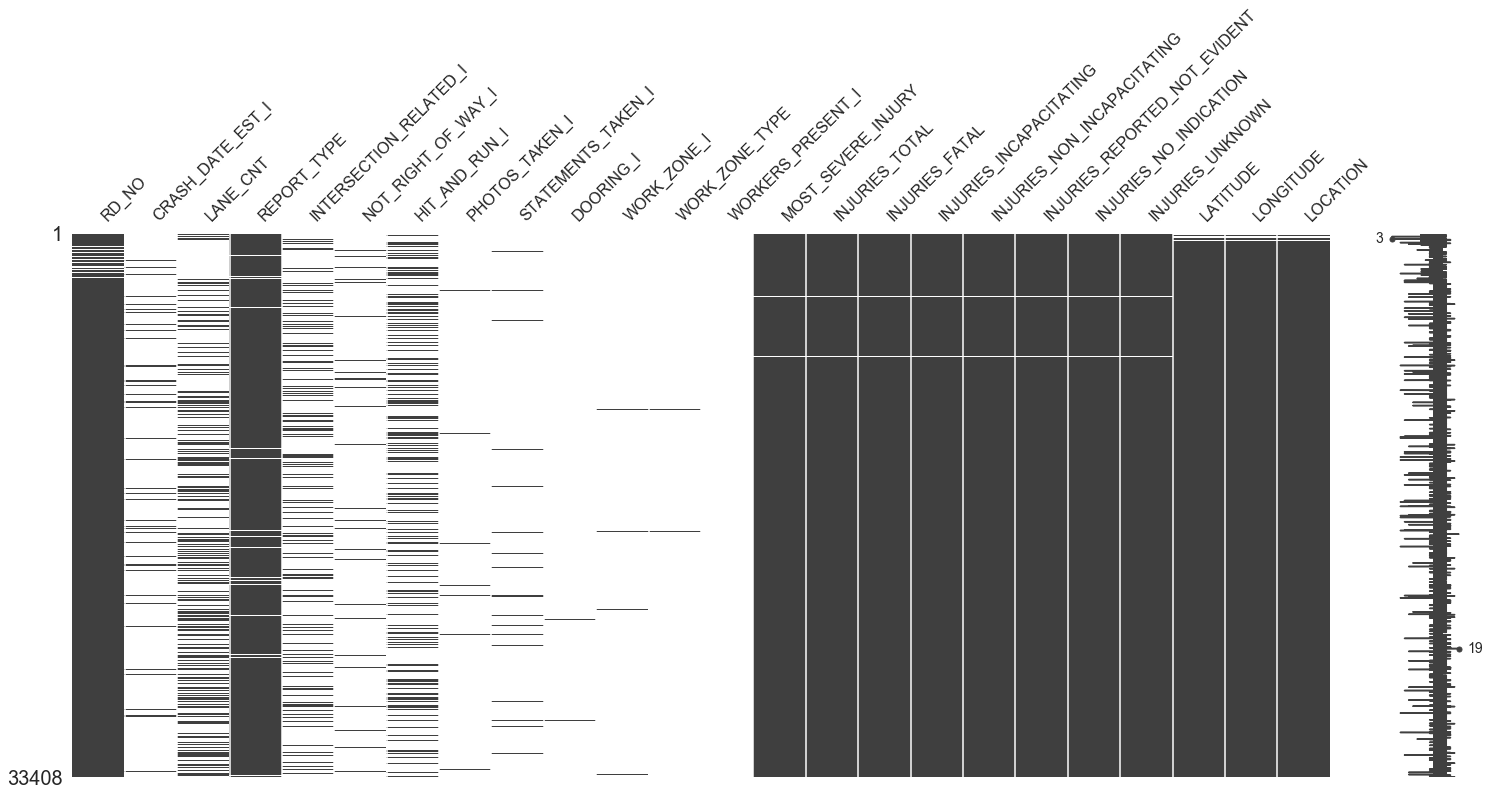

In [14]:
# List of columns that have any missing value
missingdata_crashes = crashes.columns[crashes.isnull().any()].tolist()
msno.matrix(crashes[missingdata_crashes])

**Missingness Pattern of `Vehicles`**

As 54 out of 72 features have missing values more than 50%, only remaining 18 features is visualized for the simplicity.

Seems the data are **missing at random (MAR)**, as missingness pattern is the same only within groups defined by the observed data, 

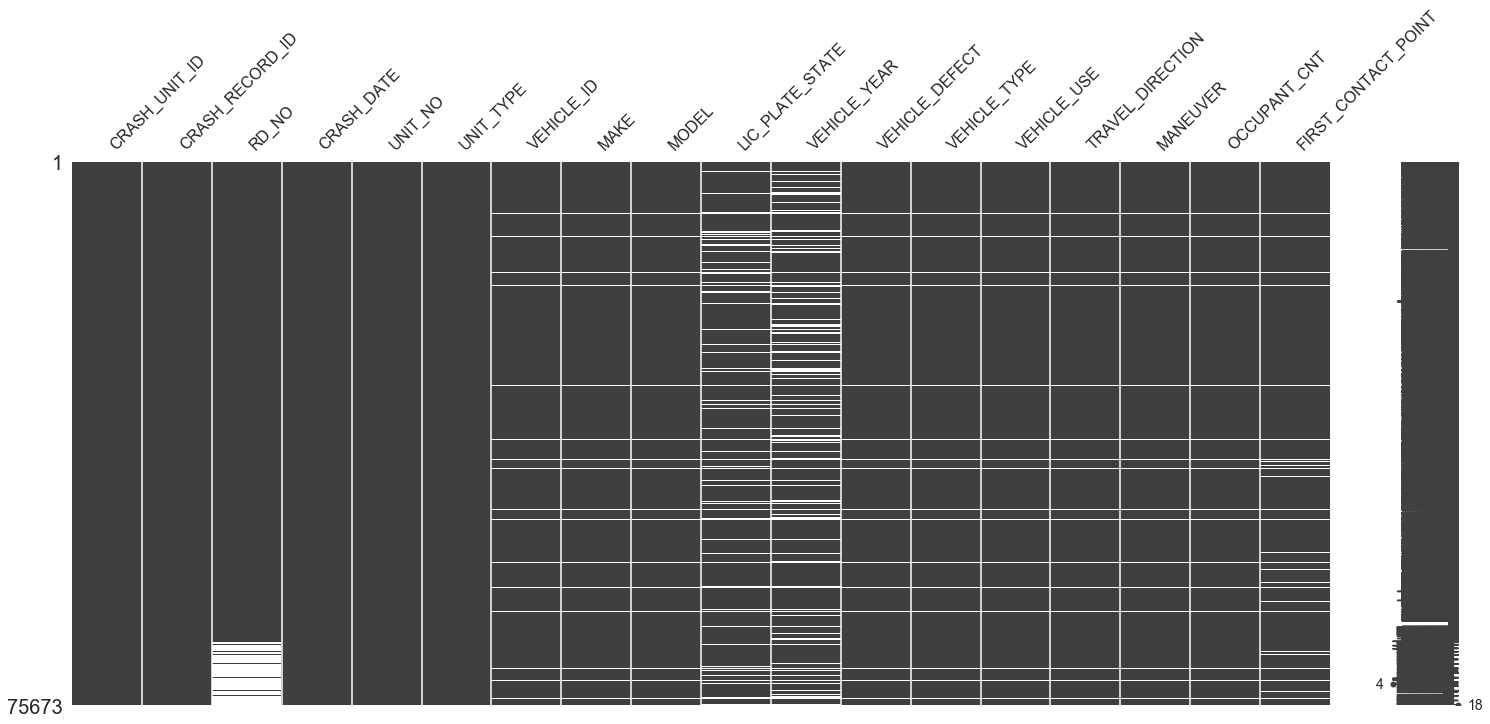

In [15]:
# List of columns that have any missing value
missingdata_vehicles = vehicles.columns[
    vehicles.isnull().mean().round(2) < 0.5].tolist()
msno.matrix(vehicles[missingdata_vehicles])

**Missingness Pattern of `People`**

Overall, both missingness pattern and correlation heatmap of People seem that features are **missing at random (MAR)**.

Sister features regarding city, driver, safety are missing together as expected  but cross features are not missing together. 

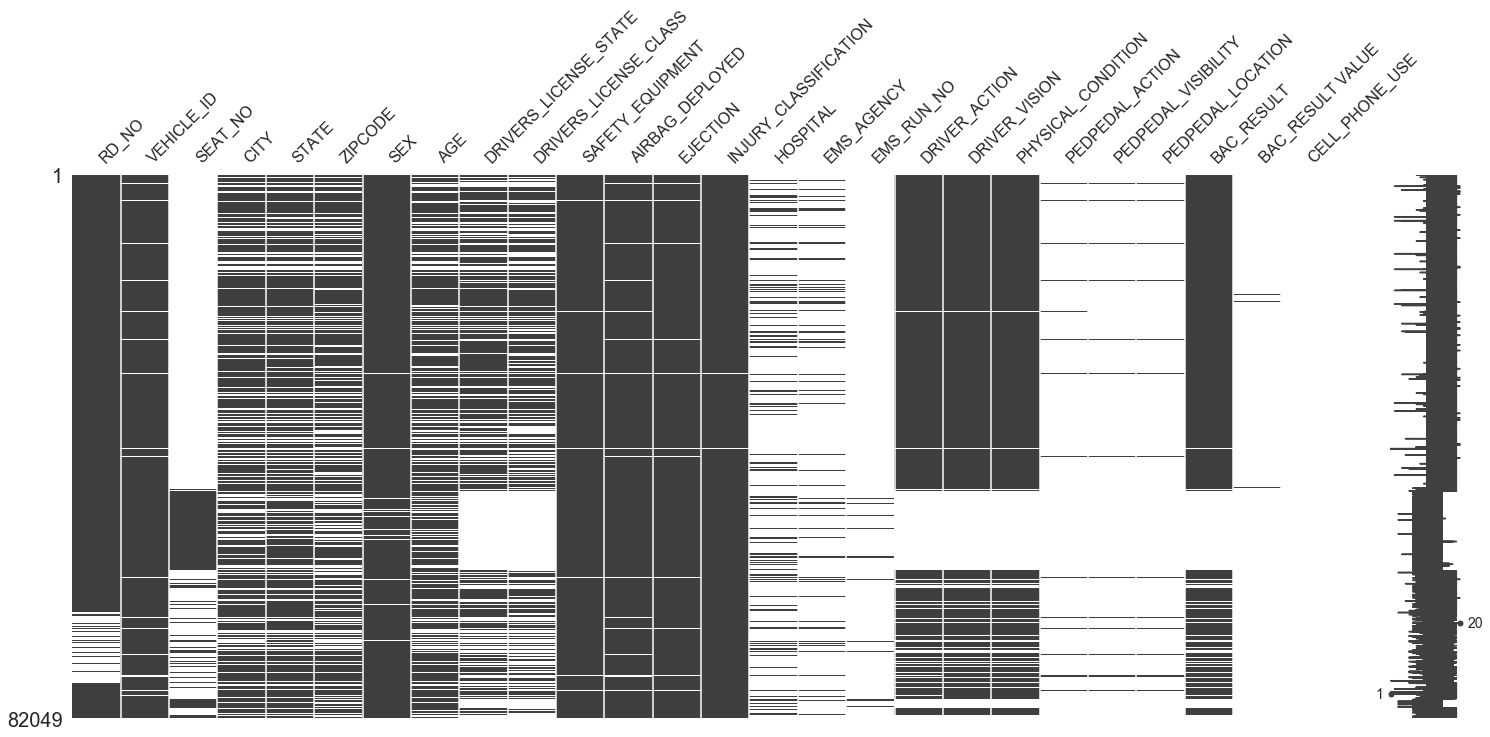

In [16]:
# List of columns that have any missing value
missingdata_people = people.columns[people.isnull().any()].tolist()
msno.matrix(people[missingdata_people])

**Correlation Heatmap of `Crashes`** 

Correlation between missing values of different columns.
This heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another and confirms above missing pattern of the dataset.


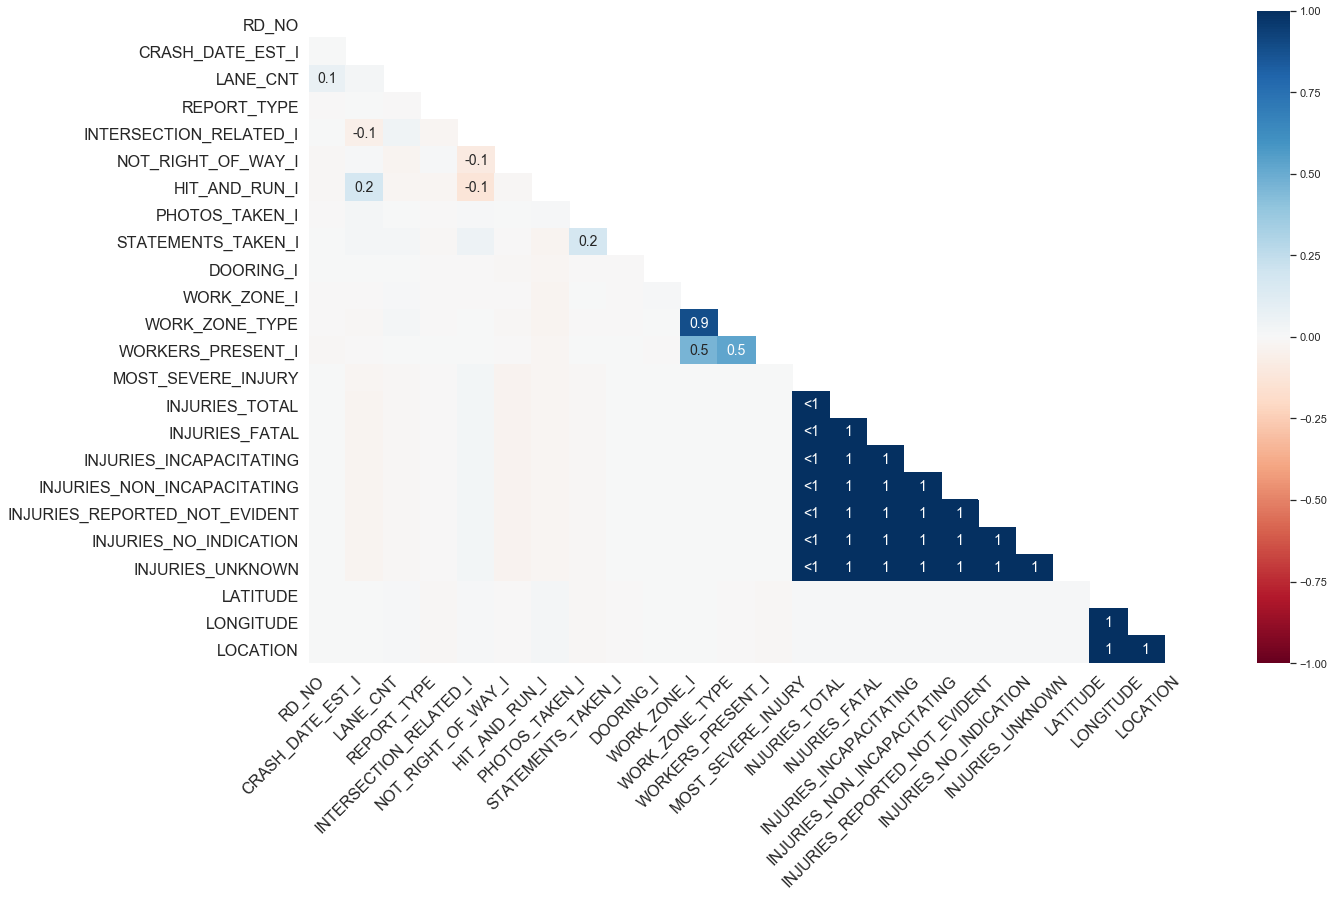

In [17]:
msno.heatmap(crashes)

**Correlation Heatmap of `People`**

Correlation between missing values in different columns

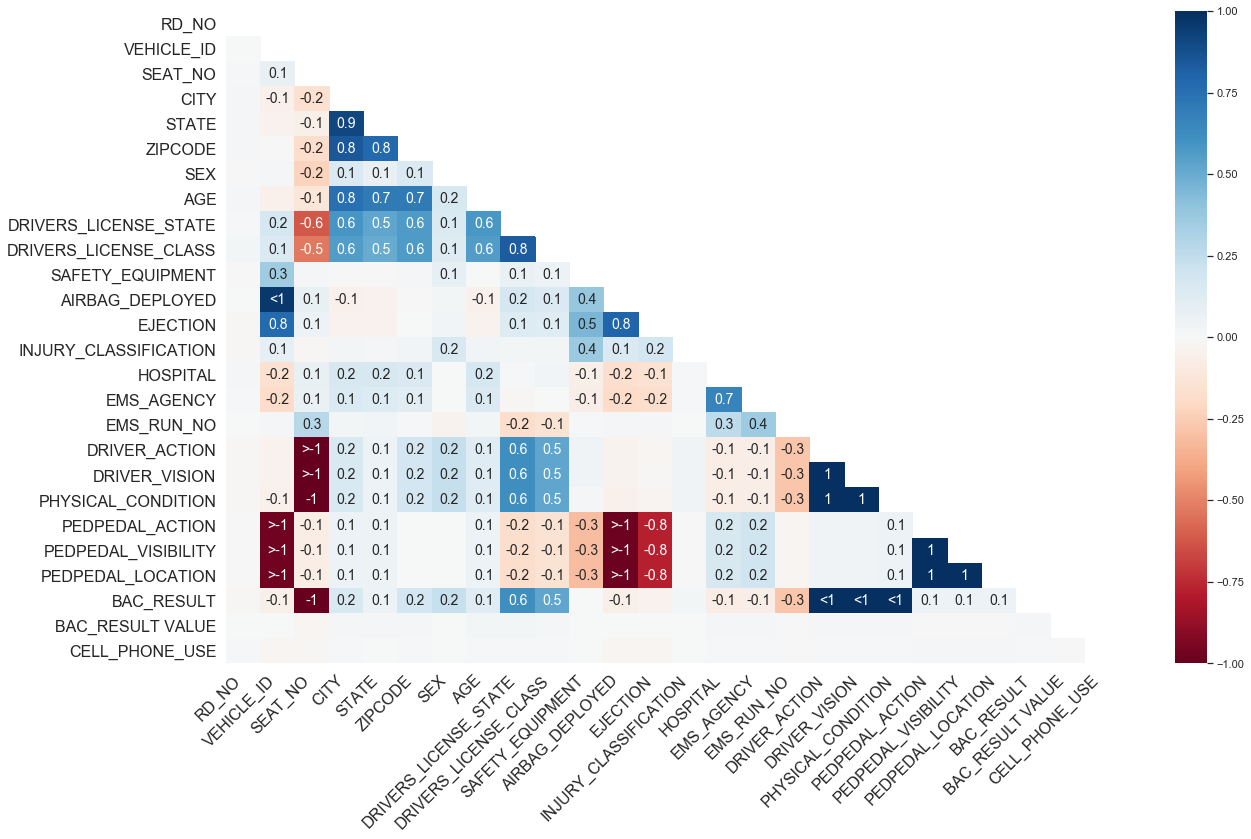

In [18]:
msno.heatmap(people)

<a id='data_distributions'></a>

## Univariate Analysis

*[Back to Top](#top)*

Crashes numerical columns

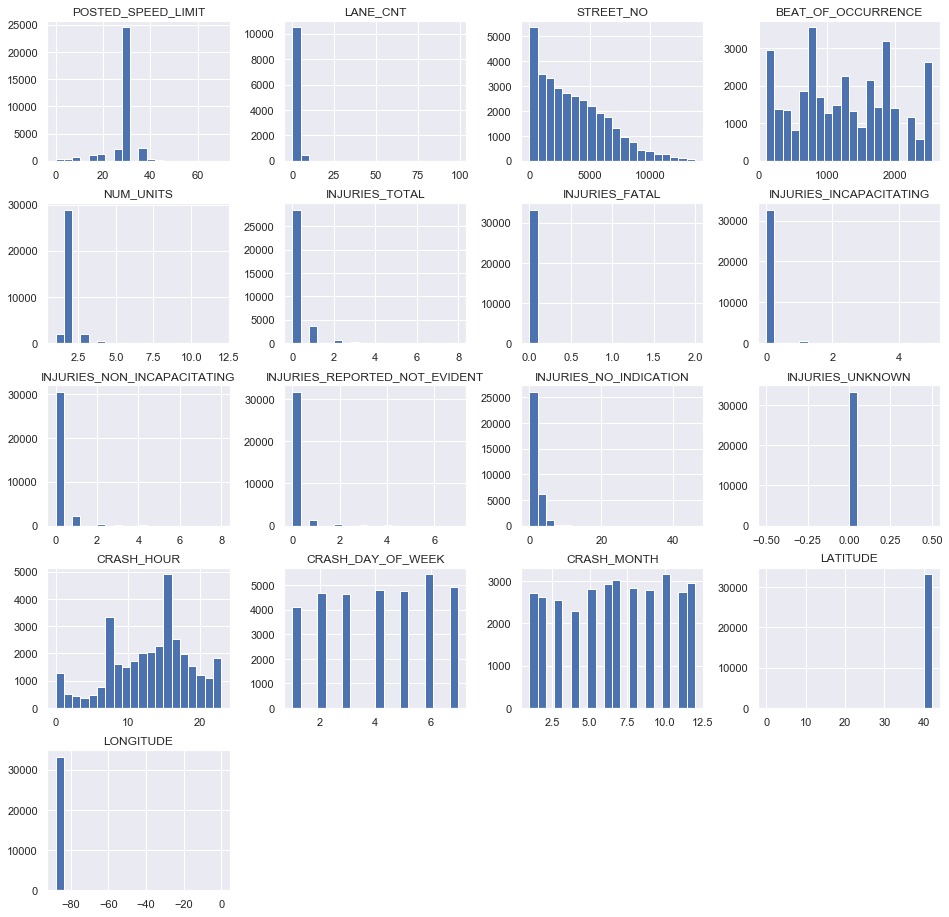

In [19]:
# Crashes numerical columns
crashes.hist(bins=20, figsize=(16, 16))
plt.show()

### Summary Statistics for numerical Columns

In [20]:
print("crashes")
display(crashes.describe())
print("vehicles")
display(vehicles.describe())
print("people")
people.describe()

crashes


POSTED_SPEED_LIMIT      LANE_CNT     STREET_NO  BEAT_OF_OCCURRENCE  \
count        33408.000000  10996.000000  33408.000000        33408.000000   
mean            28.420318      2.498272   3662.141134         1250.213332   
std              6.210942      1.669592   2847.516283          704.127405   
min              0.000000      0.000000      1.000000          111.000000   
25%             30.000000      2.000000   1240.000000          722.000000   
50%             30.000000      2.000000   3199.000000         1214.000000   
75%             30.000000      4.000000   5518.000000         1822.000000   
max             70.000000     99.000000  13758.000000         2535.000000   

          NUM_UNITS  INJURIES_TOTAL  INJURIES_FATAL  INJURIES_INCAPACITATING  \
count  33408.000000    33324.000000     33324.00000             33324.000000   
mean       2.037895        0.195205         0.00108                 0.021936   
std        0.471285        0.564194         0.03463                 0.173489   
min        1.000000        0.000000         0.00000                 0.000000   
25%        2.000000        0.000000         0.00000                 0.000000   
50%        2.000000        0.000000         0.00000                 0.000000   
75%        2.000000        0.000000         0.00000                 0.000000   
max       12.000000        8.000000         2.00000                 5.000000   

       INJURIES_NON_INCAPACITATING  INJURIES_REPORTED_NOT_EVIDENT  \
count                 33324.000000                   33324.000000   
mean                      0.109501                       0.062688   
std                       0.420830                       0.318674   
min                       0.000000                       0.000000   
25%                       0.000000                       0.000000   
50%                       0.000000                       0.000000   
75%                       0.000000                       0.000000   
max                       8.000000                       7.000000   

       INJURIES_NO_INDICATION  INJURIES_UNKNOWN    CRASH_HOUR  \
count            33324.000000           33324.0  33408.000000   
mean                 2.030729               0.0     13.152029   
std                  1.220179               0.0      5.542940   
min                  0.000000               0.0      0.000000   
25%                  1.000000               0.0      9.000000   
50%                  2.000000               0.0     14.000000   
75%                  2.000000               0.0     17.000000   
max                 46.000000               0.0     23.000000   

       CRASH_DAY_OF_WEEK   CRASH_MONTH      LATITUDE     LONGITUDE  
count       33408.000000  33408.000000  33215.000000  33215.000000  
mean            4.122815      6.660500     41.856674    -87.674102  
std             1.980078      3.438983      0.335981      0.682890  
min             1.000000      1.000000      0.000000    -87.933994  
25%             2.000000      4.000000     41.786257    -87.722139  
50%             4.000000      7.000000     41.876677    -87.674754  
75%             6.000000     10.000000     41.924907    -87.633925  
max             7.000000     12.000000     42.022720      0.000000

vehicles


CRASH_UNIT_ID       UNIT_NO  NUM_PASSENGERS     VEHICLE_ID  \
count   75673.000000  75673.000000    11633.000000   73804.000000   
mean   636542.746819      1.573243        1.479756  606345.289334   
std    229743.763303      0.654345        1.119244  215477.478218   
min    228894.000000      0.000000        1.000000  224185.000000   
25%    436244.000000      1.000000        1.000000  418742.000000   
50%    642576.000000      2.000000        1.000000  611440.500000   
75%    845390.000000      2.000000        2.000000  802301.500000   
max    970977.000000     12.000000       43.000000  920209.000000   

       VEHICLE_YEAR  OCCUPANT_CNT        CMV_ID  HAZMAT_REPORT_NO  \
count  61945.000000  73804.000000    886.000000               0.0   
mean    2012.930955      1.088762   6578.375847               NaN   
std      129.699968      0.879280   2878.475327               NaN   
min     1900.000000      0.000000   1515.000000               NaN   
25%     2006.000000      1.000000   4145.750000               NaN   
50%     2012.000000      1.000000   6602.000000               NaN   
75%     2016.000000      1.000000   9189.750000               NaN   
max     9999.000000     99.000000  10831.000000               NaN   

       MCS_REPORT_NO  TRAILER1_LENGTH  TRAILER2_LENGTH  TOTAL_VEHICLE_LENGTH  \
count            0.0       132.000000         3.000000            148.000000   
mean             NaN        48.719697        37.333333             50.858108   
std              NaN        15.010589        15.947832             21.055809   
min              NaN         1.000000        19.000000              1.000000   
25%              NaN        48.000000        32.000000             33.000000   
50%              NaN        53.000000        45.000000             56.000000   
75%              NaN        53.000000        46.500000             65.750000   
max              NaN       101.000000        48.000000             96.000000   

           AXLE_CNT  
count    239.000000  
mean     112.435146  
std     1682.148492  
min        1.000000  
25%        2.000000  
50%        3.000000  
75%        5.000000  
max    26009.000000

people


VEHICLE_ID       SEAT_NO           AGE  BAC_RESULT VALUE
count   80306.000000  17214.000000  59254.000000        134.000000
mean   602088.561652      4.193099     37.805633          0.169328
std    214429.123290      2.235407     17.150075          0.087447
min    224185.000000      1.000000      0.000000          0.000000
25%    414668.250000      3.000000     25.000000          0.120000
50%    606222.500000      3.000000     35.000000          0.170000
75%    795201.000000      6.000000     50.000000          0.210000
max    920208.000000     12.000000    110.000000          0.440000

### Value Counts for Categorical Columns

#### `crashes`
- 18 categorical variables details. 

In [21]:
for col in crashes.columns:
    if crashes[col].dtype.name == 'category':
        print('\033[1m', '\nColumn Name:', col, '\033[0m')
        print(crashes[col].value_counts())

 
Column Name: TRAFFIC_CONTROL_DEVICE 
NO CONTROLS                 19052
TRAFFIC SIGNAL               9318
STOP SIGN/FLASHER            3480
UNKNOWN                      1020
OTHER                         217
LANE USE MARKING               91
YIELD                          61
OTHER REG. SIGN                48
OTHER WARNING SIGN             28
POLICE/FLAGMAN                 20
RAILROAD CROSSING GATE         17
PEDESTRIAN CROSSING SIGN       12
SCHOOL ZONE                    12
OTHER RAILROAD CROSSING        11
FLASHING CONTROL SIGNAL         9
DELINEATORS                     8
NO PASSING                      2
RR CROSSING SIGN                1
BICYCLE CROSSING SIGN           1
Name: TRAFFIC_CONTROL_DEVICE, dtype: int64
 
Column Name: DEVICE_CONDITION 
NO CONTROLS                 19287
FUNCTIONING PROPERLY        11775
UNKNOWN                      1780
OTHER                         267
FUNCTIONING IMPROPERLY        170
NOT FUNCTIONING               113
WORN REFLECTIVE MATERIAL       11
M

#### `vehicles`
- 10 categorical variables details. 

In [22]:
for col in vehicles.columns:
    if vehicles[col].dtype.name == 'category':
        print('\033[1m', '\nColumn Name:', col, '\033[0m')
        print(vehicles[col].value_counts())

 
Column Name: UNIT_TYPE 
DRIVER                 63122
PARKED                  9995
PEDESTRIAN              1025
DRIVERLESS               719
BICYCLE                  593
NON-MOTOR VEHICLE         79
NON-CONTACT VEHICLE       16
DISABLED VEHICLE           9
EQUESTRIAN                 3
Name: UNIT_TYPE, dtype: int64
 
Column Name: MAKE 
CHEVROLET                             8580
FORD                                  7442
UNKNOWN                               7083
TOYOTA MOTOR COMPANY, LTD.            6401
NISSAN                                6313
                                      ... 
KWICK KIT CEMENT MIXER                   1
KUT-KWICK CORP. BRUNSWICK, GEORGIA       1
KON KWEST MANUFACTURING                  1
KING TRAILER CO., INC.                   1
"(ASSEMBLED FROM PARTS, HOMEMADE)"       1
Name: MAKE, Length: 326, dtype: int64
 
Column Name: MODEL 
UNKNOWN                                       12919
OTHER (EXPLAIN IN NARRATIVE)                   2772
CAMRY                    

#### `people`
- 12 categorical variables details. 

In [23]:
for col in people.columns:
    if people[col].dtype.name == 'category':
        print('\033[1m', '\nColumn Name:', col, '\033[0m')
        print(people[col].value_counts())

 
Column Name: CITY 
CHICAGO             43142
CICERO                620
SKOKIE                382
BERWYN                340
UNKNOWN               322
                    ...  
MERRELVILLE             1
MERRILLVLLE             1
MERRIONEYYE PARK        1
MERRIT ISLAND           1
60630                   1
Name: CITY, Length: 2099, dtype: int64
 
Column Name: STATE 
IL    58365
IN      952
XX      442
WI      271
MI      214
FL      145
TX      122
OH      114
CA       97
MO       84
IA       83
MN       81
GA       70
NY       65
TN       47
AZ       47
WA       43
CO       38
NC       37
PA       31
MS       30
VA       29
KS       27
MA       26
AR       25
KY       24
AL       23
MD       23
LA       23
NJ       21
OK       20
NB       19
NV       17
SC       14
ID       12
NH        9
ND        8
OR        7
UT        6
CT        6
SD        5
WV        4
WY        4
RI        3
DE        3
DC        3
NM        3
VT        2
AK        2
ME        1
HI        1
MT        1
Name: ST

<a id='data_correlation'></a>

## Correlation Analysis

*[Back to Top](#top)*

### Correlation of Categorical Variables

#### `crashes`

In [24]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

Categorical Columns correlation of crashes data


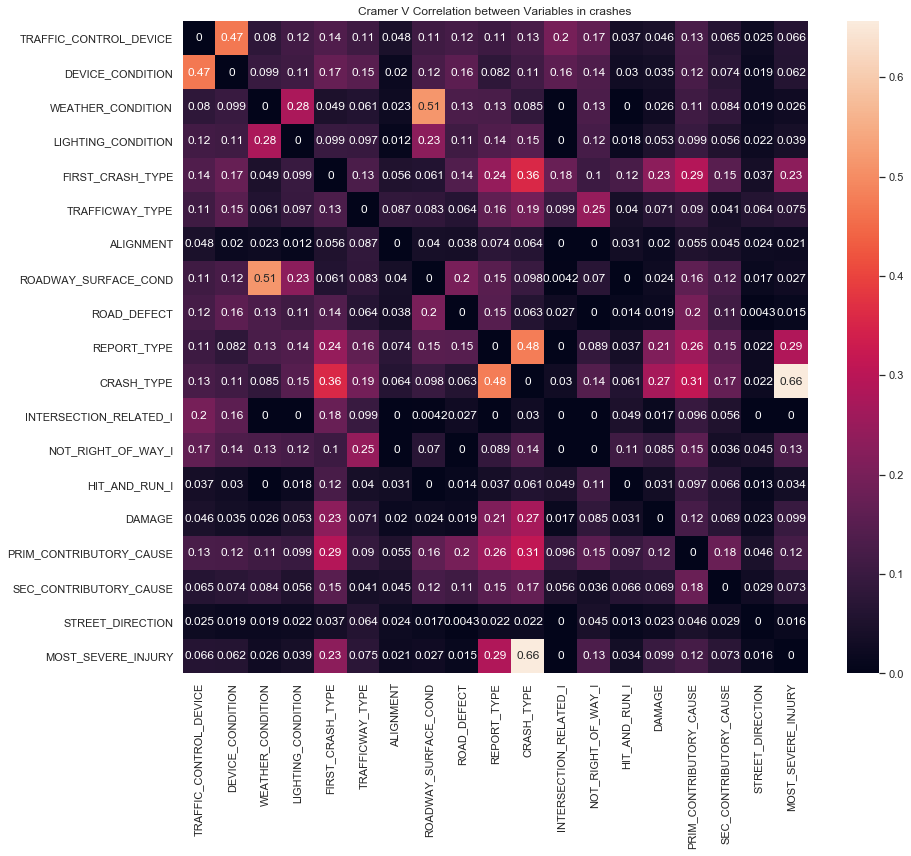

In [25]:
# Categorical Columns of crashes data
print("Categorical Columns correlation of crashes data")

cols = ["TRAFFIC_CONTROL_DEVICE", "DEVICE_CONDITION", "WEATHER_CONDITION", "LIGHTING_CONDITION", "FIRST_CRASH_TYPE", "TRAFFICWAY_TYPE", "ALIGNMENT", "ROADWAY_SURFACE_COND", "ROAD_DEFECT", "REPORT_TYPE", "CRASH_TYPE", "INTERSECTION_RELATED_I", "NOT_RIGHT_OF_WAY_I", "HIT_AND_RUN_I", "DAMAGE", "PRIM_CONTRIBUTORY_CAUSE", "SEC_CONTRIBUTORY_CAUSE", "STREET_DIRECTION", "MOST_SEVERE_INJURY"]
corrM = np.zeros((len(cols),len(cols)))

for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(crashes[col1], crashes[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(14, 12))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer V Correlation between Variables in crashes");

#### `vehicles`

Categorical Columns correlation of vehicles data


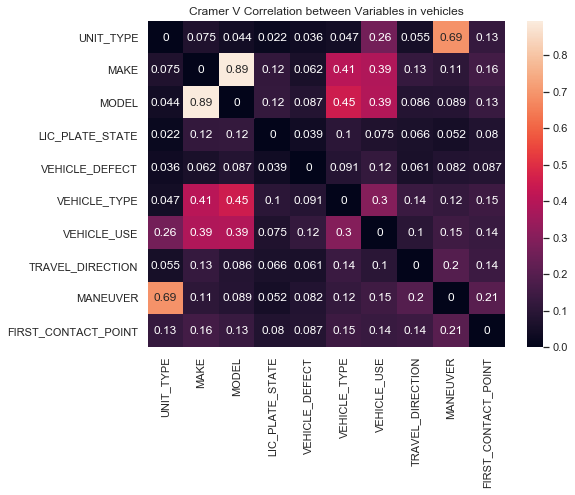

In [26]:
# Categorical Columns of vehicles data
print("Categorical Columns correlation of vehicles data")

cols = ["UNIT_TYPE", "MAKE", "MODEL", "LIC_PLATE_STATE", "VEHICLE_DEFECT", "VEHICLE_TYPE", "VEHICLE_USE", "TRAVEL_DIRECTION", "MANEUVER", "FIRST_CONTACT_POINT"]
corrM = np.zeros((len(cols),len(cols)))

for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(vehicles[col1], vehicles[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer V Correlation between Variables in vehicles");

#### `people`

Categorical Columns correlation of people data


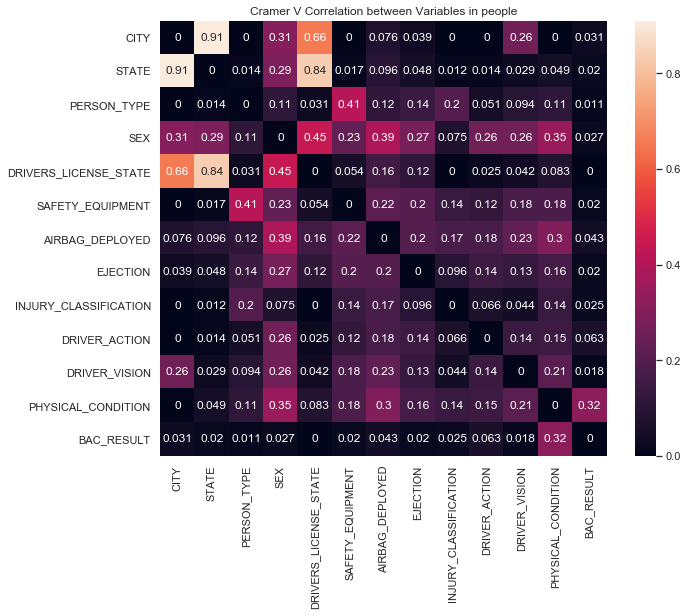

In [27]:
# Categorical Columns of people data
print("Categorical Columns correlation of people data")

cols = ["CITY", "STATE", "PERSON_TYPE", "SEX", "DRIVERS_LICENSE_STATE", "SAFETY_EQUIPMENT", "AIRBAG_DEPLOYED", "EJECTION", "INJURY_CLASSIFICATION", "DRIVER_ACTION", "DRIVER_VISION", "PHYSICAL_CONDITION", "BAC_RESULT"]
corrM = np.zeros((len(cols),len(cols)))

for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(people[col1], people[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer V Correlation between Variables in people");

### Hypothesis Testing for Categorical Columns

Let's test a few hypothesis about the relations between above features in the dataset.

**H0, the null hypothesis** is always a hypothesis of **no change** to check whether we have enough evidence to reject it.

To check and identify any possible association/correlation statistically, 
- **Pearson Correlation Coefficient** will be used between two **continuous** variables. 
- **Chi-Squared Test** will be used between two **categorical** variables.

#### Feature 1

**H0: The crash_type has no impact on the probability of the most_severe_injury.**

The first hypothesis to test would be whether or not the probability of any most_severe_injury to occur depends on the crash_type.

In [28]:
table1, results1 = rp.crosstab(crashes['CRASH_TYPE'], crashes['MOST_SEVERE_INJURY'], 
                             prop='col', test='chi-square')
table1

MOST_SEVERE_INJURY                        \
MOST_SEVERE_INJURY                            FATAL INCAPACITATING INJURY   
CRASH_TYPE                                                                  
INJURY AND / OR TOW DUE TO CRASH              100.0                 100.0   
NO INJURY / DRIVE AWAY                          0.0                   0.0   
All                                           100.0                 100.0   

                                                          \
MOST_SEVERE_INJURY               NO INDICATION OF INJURY   
CRASH_TYPE                                                 
INJURY AND / OR TOW DUE TO CRASH                   15.89   
NO INJURY / DRIVE AWAY                             84.11   
All                                               100.00   

                                                           \
MOST_SEVERE_INJURY               NONINCAPACITATING INJURY   
CRASH_TYPE                                                  
INJURY AND / OR TOW DUE TO CRASH                    100.0   
NO INJURY / DRIVE AWAY                                0.0   
All                                                 100.0   

                                                                
MOST_SEVERE_INJURY               REPORTED, NOT EVIDENT     All  
CRASH_TYPE                                                      
INJURY AND / OR TOW DUE TO CRASH                 100.0   27.94  
NO INJURY / DRIVE AWAY                             0.0   72.06  
All                                              100.0  100.00

In [29]:
results1

Chi-square test     results
0  Pearson Chi-square ( 4.0) =   14367.6149
1                    p-value =       0.0000
2                 Cramer's V =       0.6566

#### Feature 2

**H0: The MANEUVER has no impact on the probability of the UNIT_TYPE.**

The first hypothesis to test would be whether or not the probability of any MANEUVER to occur depends on the UNIT_TYPE.

- UNIT_TYPE: The type of unit
- MANEUVER: The action the unit was taking prior to the crash, as determined by the reporting officer

In [30]:
table2, results2 = rp.crosstab(vehicles['MANEUVER'], vehicles['UNIT_TYPE'], 
                             prop='col', test='chi-square')
    
table2

UNIT_TYPE                     \
UNIT_TYPE                          DISABLED VEHICLE  DRIVER DRIVERLESS   
MANEUVER                                                                 
AVOIDING VEHICLES/OBJECTS                       0.0    0.51       0.14   
BACKING                                         0.0    4.75       0.42   
CHANGING LANES                                  0.0    2.24       0.28   
DISABLED                                      100.0    0.00       0.14   
DIVERGING                                       0.0    0.01       0.00   
DRIVERLESS                                      0.0    0.00       3.20   
DRIVING WRONG WAY                               0.0    0.19       0.00   
ENTER FROM DRIVE/ALLEY                          0.0    0.50       0.00   
ENTERING TRAFFIC LANE FROM PARKING              0.0    1.33       0.00   
LEAVING TRAFFIC LANE TO PARK                    0.0    0.59       0.00   
MERGING                                         0.0    0.85       0.00   
NEGOTIATING A CURVE                             0.0    0.16       0.00   
OTHER                                           0.0    1.98       1.53   
PARKED                                          0.0    0.00      80.92   
PARKED IN TRAFFIC LANE                          0.0    0.00       2.65   
PASSING/OVERTAKING                              0.0    2.70       0.14   
SKIDDING/CONTROL LOSS                           0.0    0.55       0.00   
SLOW/STOP - LEFT TURN                           0.0    0.28       0.00   
SLOW/STOP - LOAD/UNLOAD                         0.0    0.15       0.14   
SLOW/STOP - RIGHT TURN                          0.0    0.19       0.00   
SLOW/STOP IN TRAFFIC                            0.0    9.15       0.14   
STARTING IN TRAFFIC                             0.0    0.69       0.00   
STRAIGHT AHEAD                                  0.0   52.87       3.90   
TURNING LEFT                                    0.0    7.04       0.28   
TURNING ON RED                                  0.0    0.05       0.00   
TURNING RIGHT                                   0.0    3.85       0.14   
U-TURN                                          0.0    0.65       0.00   
UNKNOWN/NA                                      0.0    8.72       5.99   
All                                           100.0  100.00     100.00   

                                                                        
UNIT_TYPE                          NON-CONTACT VEHICLE  PARKED     All  
MANEUVER                                                                
AVOIDING VEHICLES/OBJECTS                          0.0    0.00    0.44  
BACKING                                            0.0    0.00    4.06  
CHANGING LANES                                     0.0    0.00    1.92  
DISABLED                                           0.0    0.00    0.01  
DIVERGING                                          0.0    0.00    0.01  
DRIVERLESS                                         0.0    0.04    0.04  
DRIVING WRONG WAY                                  0.0    0.00    0.16  
ENTER FROM DRIVE/ALLEY                             0.0    0.04    0.44  
ENTERING TRAFFIC LANE FROM PARKING                 0.0    0.00    1.14  
LEAVING TRAFFIC LANE TO PARK                       0.0    0.00    0.50  
MERGING                                            0.0    0.00    0.73  
NEGOTIATING A CURVE                                0.0    0.00    0.13  
OTHER                                              0.0    0.02    1.71  
PARKED                                             0.0   97.56   13.99  
PARKED IN TRAFFIC LANE                             0.0    1.70    0.26  
PASSING/OVERTAKING                                40.0    0.00    2.31  
SKIDDING/CONTROL LOSS                              0.0    0.00    0.47  
SLOW/STOP - LEFT TURN                              0.0    0.00    0.24  
SLOW/STOP - LOAD/UNLOAD                            0.0    0.00    0.13  
SLOW/STOP - RIGHT TURN                             0.0    0.00    0

In [31]:
results2

Chi-square test      results
0  Pearson Chi-square ( 108.0) =   140970.2866
1                      p-value =        0.0000
2                   Cramer's V =        0.6910

### Correlation of Continuous Variables

#### `crashes`

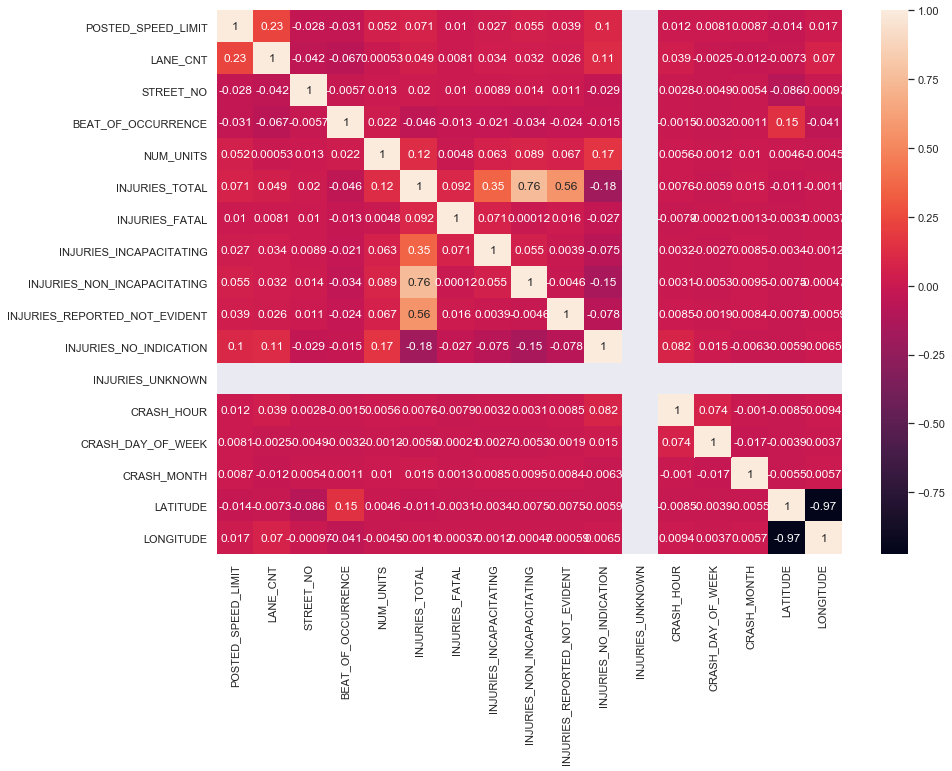

In [32]:
# Correlation heatmap of crashes numerical columns
crashes_c = pd.DataFrame(crashes,columns=crashes.select_dtypes(include=['int', 'float']).columns.tolist())
corrMatrix = crashes_c.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corrMatrix, annot=True)
plt.show()

#### `vehicles`

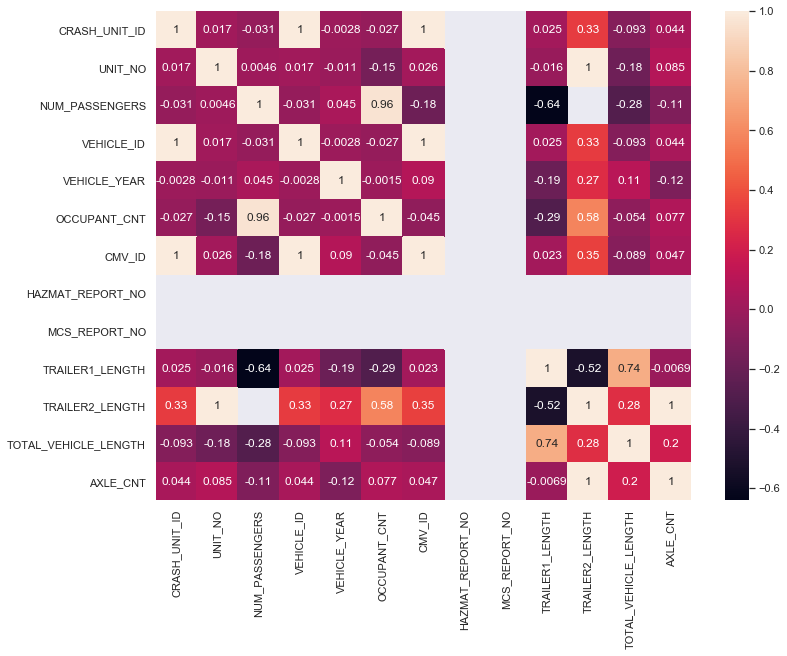

In [33]:
# Correlation heatmap of vehicles numerical columns
vehicles_c = pd.DataFrame(vehicles,columns=vehicles.select_dtypes(include=['int', 'float']).columns.tolist())
corrMatrix = vehicles_c.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(corrMatrix, annot=True)
plt.show()

#### `people`

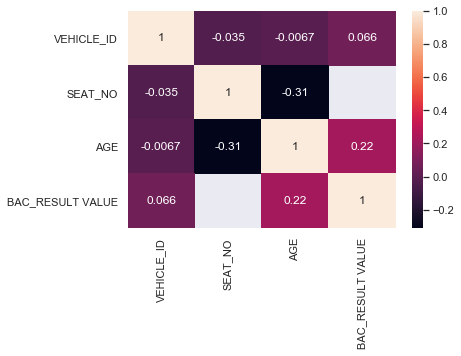

In [34]:
# Correlation heatmap of people numerical columns
people_c = pd.DataFrame(people,columns=people.select_dtypes(include=['int', 'float']).columns.tolist())
corrMatrix = people_c.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corrMatrix, annot=True)
plt.show()

<a id='data_different'></a>

## Further Analysis

*[Back to Top](#top)*

### Analysis of Geographical Data

**Geographical distribution of the Crashes**

In [35]:
# temporary drop NA in LOCATION column to plot
df_crashes = pd.read_csv("data/crashes.sample2020.csv")
crashes.dropna(subset=['LOCATION'],inplace=True)
df_crashes.dropna(subset=['LOCATION'],inplace=True)
df_crashes.reset_index(drop=True,inplace=True)
chicago_map = folium.Map(location=[41.864073,-87.706819], zoom_start=10.5)

In [36]:
# convert to (n, 2) nd-array format for heatmap
stationArr = df_crashes[['LATITUDE', 'LONGITUDE']].values
# plot heatmap
chicago_map.add_child(plugins.HeatMap(stationArr, radius=11))
chicago_map

**Monthly crashes distribution**

In [37]:
# Left Merge the data and temporary drop NA on vehicle/UNIT_TYPE column
df_vehicle = pd.read_csv("data/vehicles.sample.csv", low_memory=False)

# dropping NAN values for UNIT_TYPE
df_vehicle.dropna(subset=['UNIT_TYPE'],inplace=True)
df_vehicle.reset_index(drop=True,inplace=True)

# merging vehicle with Crash dataset
df = df_vehicle.groupby('CRASH_RECORD_ID')['UNIT_TYPE'].apply(','.join).reset_index()
df = df.merge(df_vehicle.groupby('CRASH_RECORD_ID')[['MAKE','VEHICLE_YEAR','VEHICLE_TYPE','VEHICLE_USE',
                                                     'TRAVEL_DIRECTION','MANEUVER','OCCUPANT_CNT',
                                                     'FIRST_CONTACT_POINT']].first().reset_index(),how='left',
                                                    on='CRASH_RECORD_ID')

df_new = df_crashes.merge(df, how='left',on='CRASH_RECORD_ID')

# parsing time
df_new["CRASH_DATE"]=pd.to_datetime(df_new["CRASH_DATE"])

# forming data for time analysis using heatmap in folium across months
lat_long_list = []
for yr in range(df_new["CRASH_DATE"].min().year,df_new["CRASH_DATE"].max().year):
    for i in range(1,13):
        lat_long_list.append(df_new[(df_new["CRASH_DATE"].dt.year==yr) & (df_new["CRASH_MONTH"]==i)][["LATITUDE","LONGITUDE"]].values.tolist())

# loading heatmap with time plugin in folium
chicago_new_map = folium.Map(location=[41.864073,-87.706819], zoom_start=11)
plugins.HeatMapWithTime(lat_long_list,radius=8,auto_play=True,position='bottomright').add_to(chicago_new_map)
chicago_new_map

**Hourly crashes distribution**

In [38]:
# forming data for time analysis using heatmap in folium across time of day
lat_long_list_2 = []
for i in range(0,24):
    lat_long_list_2.append(df_new[(df_new["CRASH_HOUR"]==i)][["LATITUDE","LONGITUDE"]].values.tolist())
    
# loading heatmap with time plugin in folium
chicago_new_map_2 = folium.Map(location=[41.864073,-87.706819], zoom_start=11)
plugins.HeatMapWithTime(lat_long_list_2,radius=8,auto_play=True,position='bottomright').add_to(chicago_new_map_2)
chicago_new_map_2

### Analysis of Time Data

In [39]:
# on Crashes
crashes_ts = crashes.copy()
# Convert Crash_data into time
crashes_ts['CRASH_DATE'] = pd.to_datetime(crashes_ts.CRASH_DATE)
# Creating three new columns for easy querying
crashes_ts['YEAR'] = crashes_ts.CRASH_DATE.dt.year
crashes_ts['MONTH'] = crashes_ts.CRASH_DATE.dt.month
crashes_ts['DAY'] = crashes_ts.CRASH_DATE.dt.day
# Function to compare considered feature with time

def time_pivot(data, x):
    tdf = data[['YEAR', x]].groupby(['YEAR', x]).size().rename('Count').reset_index()
    return pd.pivot_table(tdf, columns = 'YEAR', index = x)

In [40]:
# Year vs. Crash Type => Mostly No injury/drive away

time_pivot(crashes_ts, "CRASH_TYPE").sort_values(by = ('Count', 2017), ascending = False)

Count                  
YEAR                              2017  2018  2019  2020
CRASH_TYPE                                              
NO INJURY / DRIVE AWAY            2069  8681  8372  4803
INJURY AND / OR TOW DUE TO CRASH   776  3222  3134  2158

In [41]:
# Year vs Damages. => Most of our data are at between 2018-2019

time_pivot(crashes_ts, 'DAMAGE').sort_values(by = ('Count', 2017), ascending = False)

Count                  
YEAR           2017  2018  2019  2020
DAMAGE                               
OVER $1,500    1626  6897  6671  4301
$501 - $1,500   848  3401  3278  1916
$500 OR LESS    371  1605  1557   744

Friday seems to have slightly higher crashes.

[Text(0, 0, 'Sunday'),
 Text(0, 0, 'Monday'),
 Text(0, 0, 'Tuesday'),
 Text(0, 0, 'Wednesday'),
 Text(0, 0, 'Thursday'),
 Text(0, 0, 'Friday'),
 Text(0, 0, 'Saturday')]

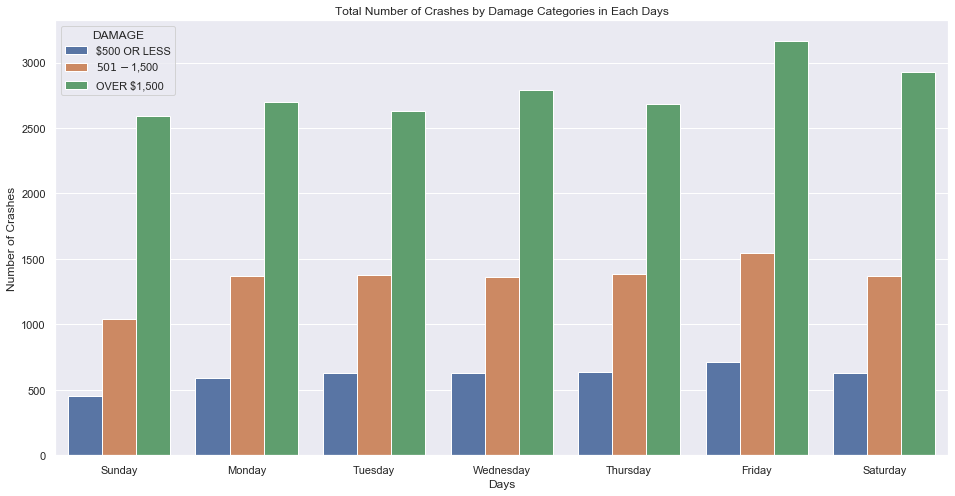

In [42]:
sns.set(rc={'figure.figsize':(16,8)})
ax=sns.countplot(x='CRASH_DAY_OF_WEEK', hue='DAMAGE', data=crashes)
ax.set(xlabel = 'Days', title = 'Total Number of Crashes by Damage Categories in Each Days',
       ylabel = "Number of Crashes")
ax.set_xticklabels(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

### Analysis of Categorical Data

(array([0, 1, 2]), <a list of 3 Text yticklabel objects>)

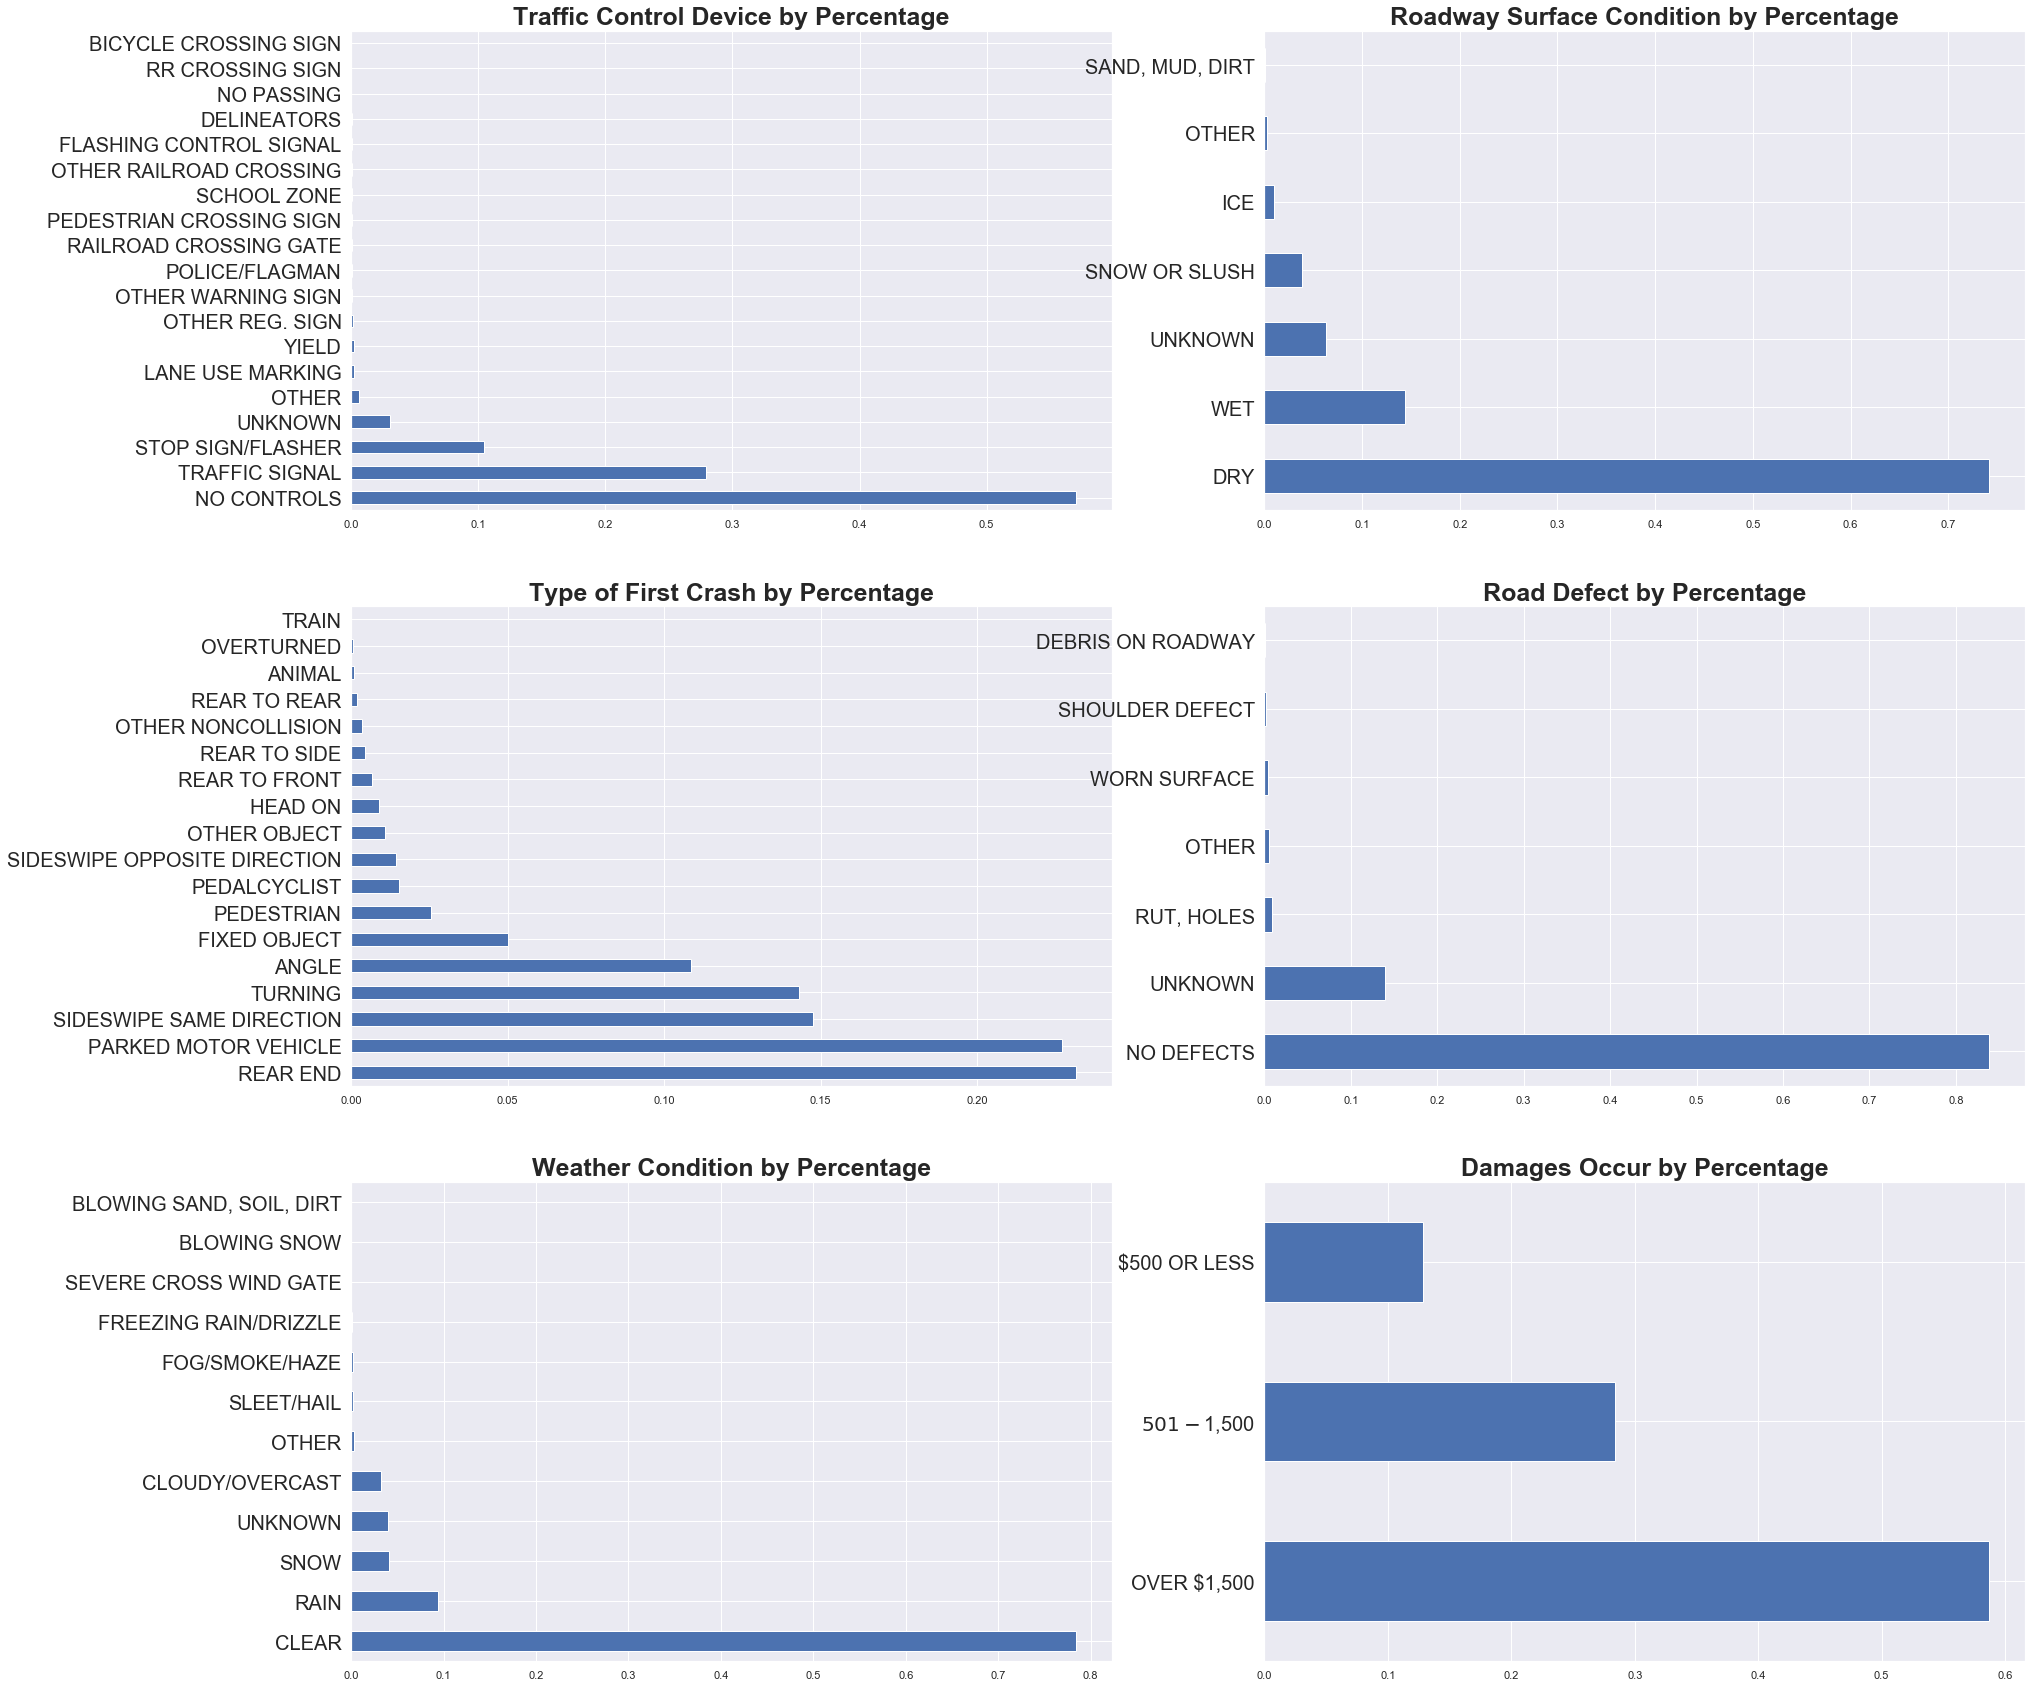

In [43]:
# Crashes categorical data details
plt.figure(figsize=(30, 30))

# Traffic Control
plt.subplot(3, 2, 1)
crashes.TRAFFIC_CONTROL_DEVICE.value_counts(normalize = True).plot.barh()
plt.title("Traffic Control Device by Percentage", fontsize=25, fontweight="bold")
plt.yticks(fontsize=20)

# Road Condition
plt.subplot(3, 2, 2)
crashes.ROADWAY_SURFACE_COND.value_counts(normalize = True).plot.barh()
plt.title("Roadway Surface Condition by Percentage", fontsize=25, fontweight="bold")
plt.yticks(fontsize=20)

# Crash Type
plt.subplot(3, 2, 3)
crashes.FIRST_CRASH_TYPE.value_counts(normalize = True).plot.barh()
plt.title("Type of First Crash by Percentage", fontsize=25, fontweight="bold")
plt.yticks(fontsize=20)

#Road Defect
plt.subplot(3, 2, 4)
crashes.ROAD_DEFECT.value_counts(normalize = True).plot.barh()
plt.title("Road Defect by Percentage", fontsize=25, fontweight="bold")
plt.yticks(fontsize=20)

# Weather Condition
plt.subplot(3, 2, 5)
crashes.WEATHER_CONDITION.value_counts(normalize = True).plot.barh()
plt.title("Weather Condition by Percentage", fontsize=25, fontweight="bold")
plt.yticks(fontsize=20)

# Damage from crashes
plt.subplot(3, 2, 6)
crashes.DAMAGE.value_counts(normalize = True).plot.barh()
plt.title("Damages Occur by Percentage", fontsize=25, fontweight="bold")
plt.yticks(fontsize=20)

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]),
 <a list of 10 Text xticklabel objects>)

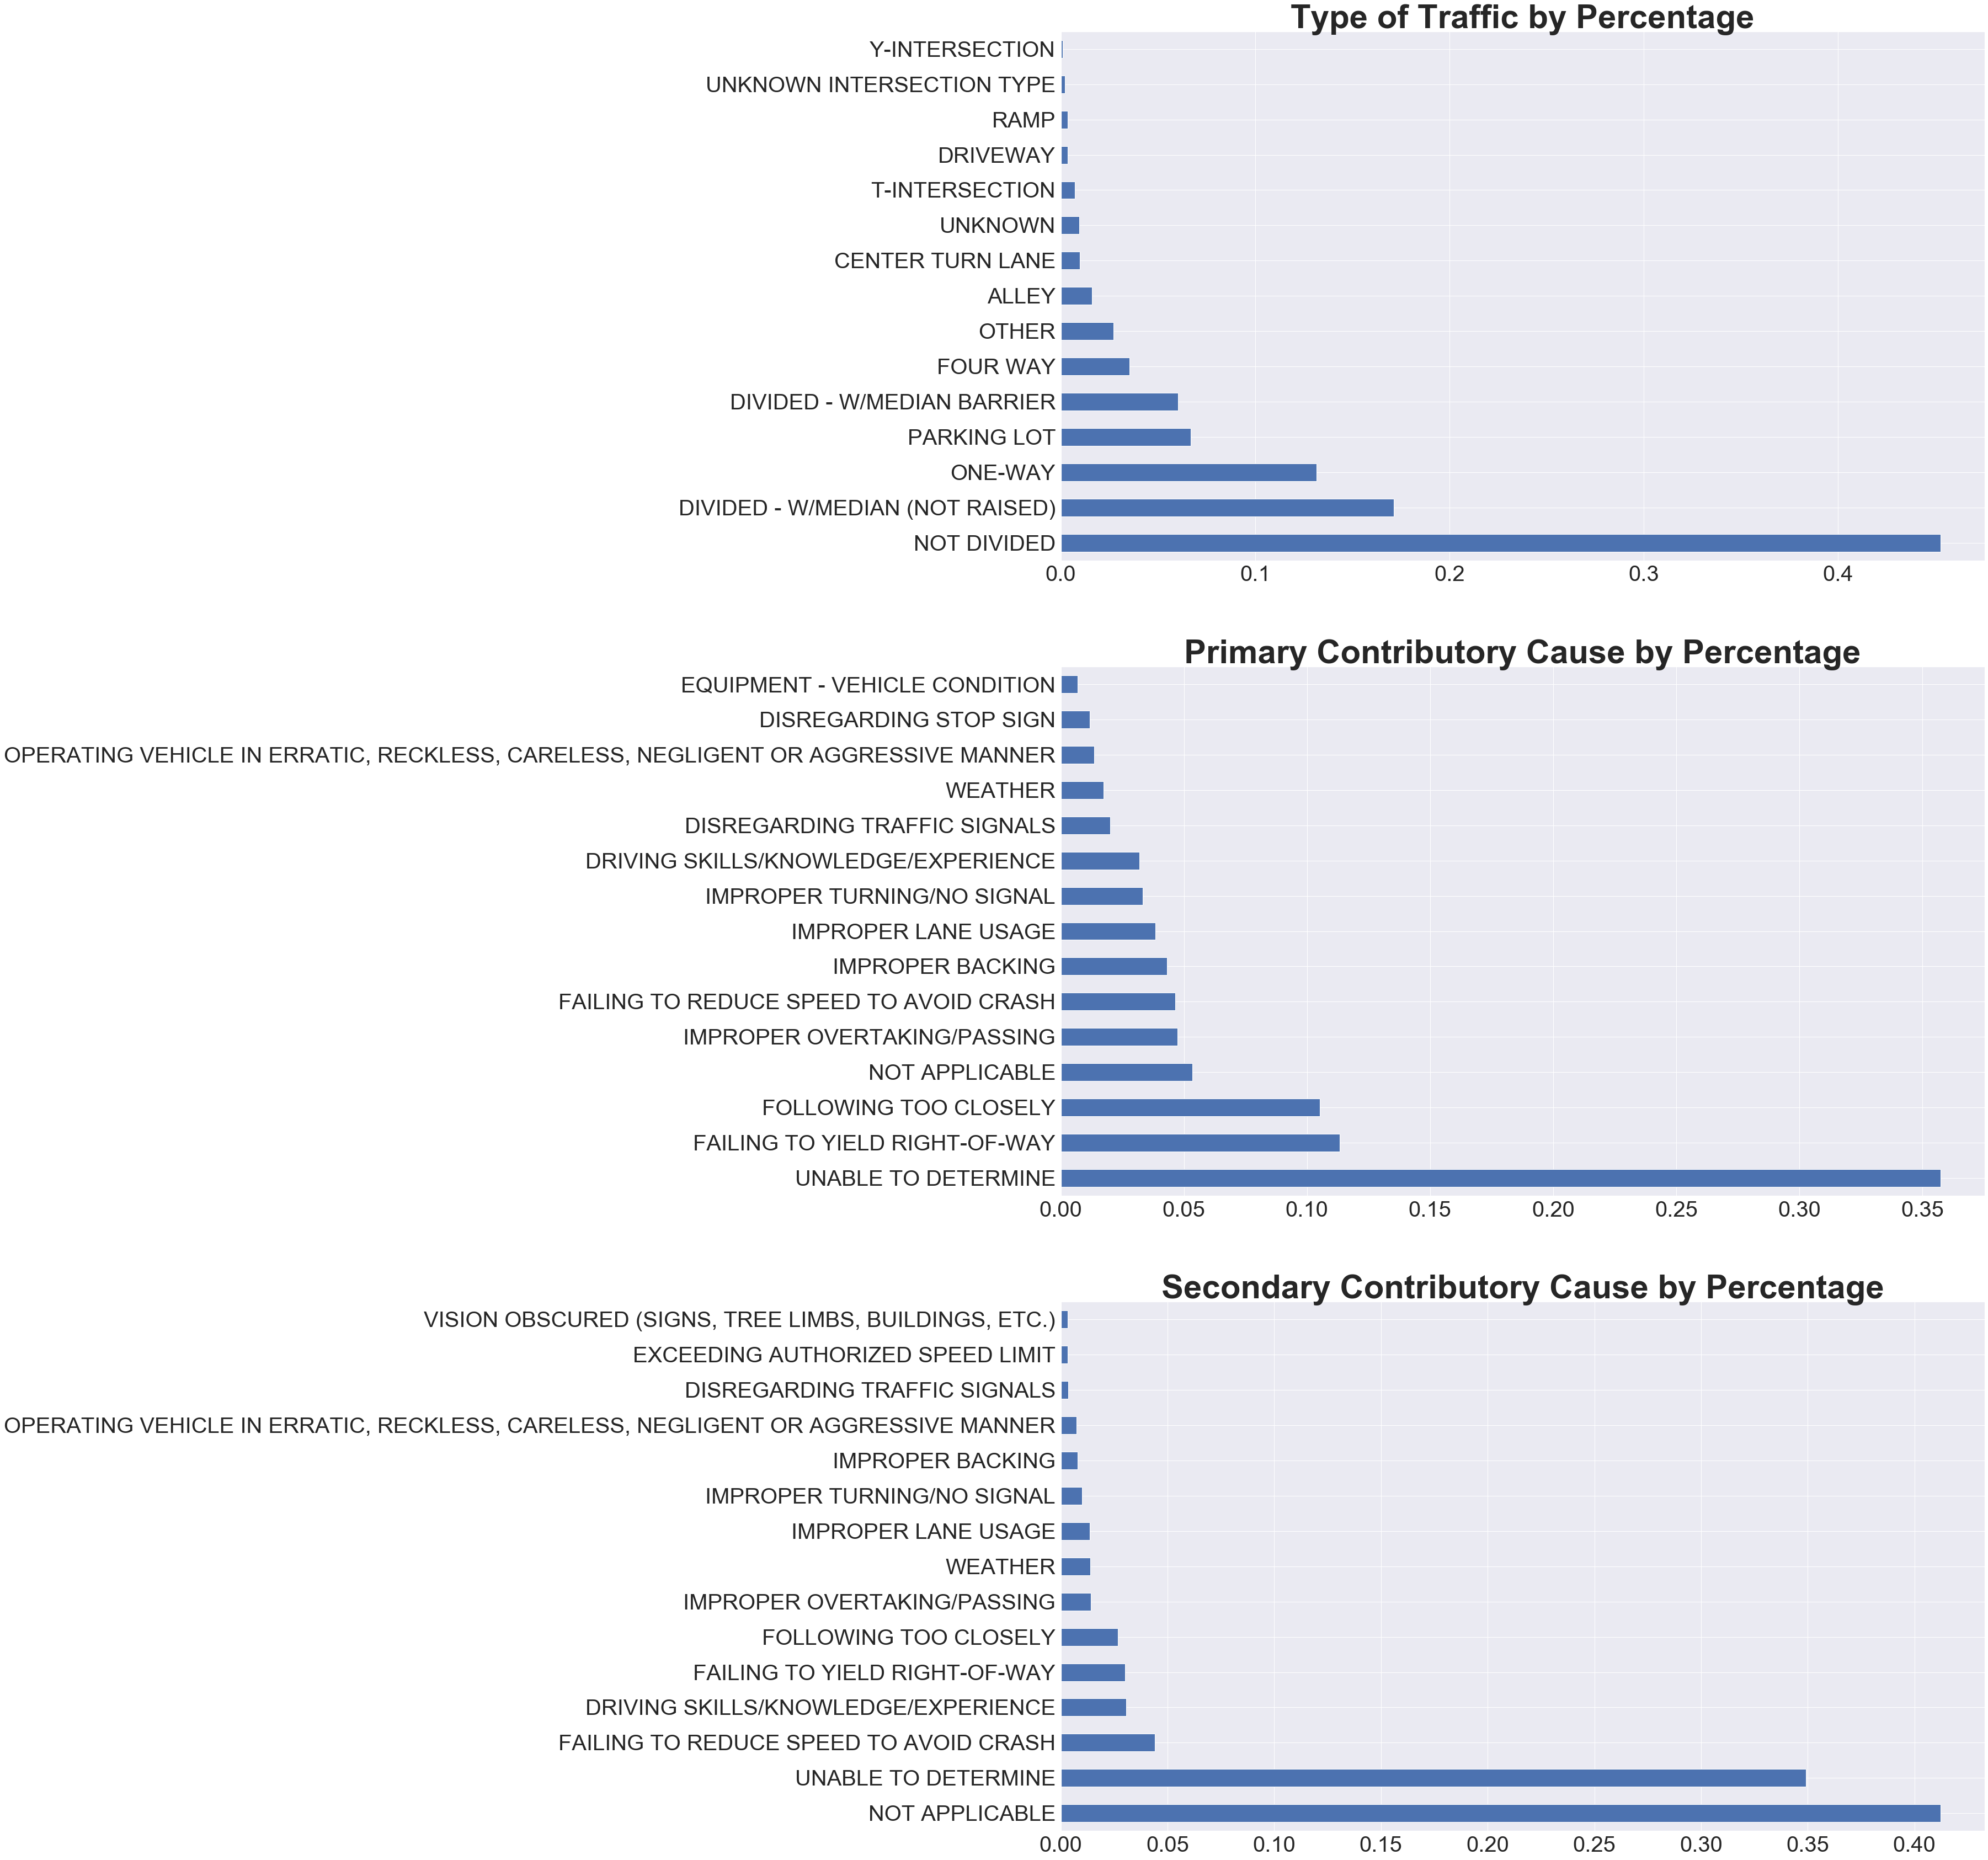

In [44]:
plt.figure(figsize=(30, 60))

# Type of Traffic
plt.subplot(3, 1, 1)
crashes.TRAFFICWAY_TYPE.value_counts(normalize=True)[:15].plot.barh()
plt.title('Type of Traffic by Percentage', fontsize=60, fontweight="bold")
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)

# Primary Contributory Cause
plt.subplot(3, 1, 2)
crashes.PRIM_CONTRIBUTORY_CAUSE.value_counts(normalize = True)[:15].plot.barh()
plt.title("Primary Contributory Cause by Percentage", fontsize=60, fontweight="bold")
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)

# Secondary Contributory Cause
plt.subplot(3, 1, 3)
crashes.SEC_CONTRIBUTORY_CAUSE.value_counts(normalize = True)[:15].plot.barh()
plt.title("Secondary Contributory Cause by Percentage", fontsize=60, fontweight="bold")
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)

### Analysis of Deeper insights

- **DRIVER to DRIVER :** 2 or more drivers are involved in the crash (only drivers).

- **ONLY DRIVER :** Only 1 driver is involved.

- **DRIVER WITH OTHERS :** DRIVER with ex: bicycler, pedestrian.

- **DRIVER to DRIVER with OTHERS :** 2 or more drivers are involved along with ex: bicycle.

- **NO DRIVER :** The rest.

In [45]:
# regrouping objects involved in Accidents into more meaningful representation
def who_were(x):
    if (len(x)==1) and (x[0]=='DRIVER'):
        return "ONLY DRIVER"
    elif (x.count("DRIVER")>=2) and (len(set(x))==1):
        return "DRIVER to DRIVER"
    elif x.count("DRIVER")>=2 and len(set(x))>1:
        return "DRIVER to DRIVER WITH OTHERS  (BICYCLE,PARKED,PEDESTRIAN etc.)"
    elif x.count("DRIVER")==1 and len(x)>1:
        return "DRIVER WITH OTHERS (BICYCLE,PARKED,PEDESTRIAN etc.)"
    else:
        return "NO DRIVER"
        
df_new['UNIT_TYPE'] = df_new['UNIT_TYPE'].apply(lambda x: who_were(x.split(',')))

# regrouping contact point into same categories
def contact_point(x):
    if "FRONT" in x:
        return "FRONT"
    elif "SIDE" in x:
        return "SIDE"
    elif "REAR" in x:
        return "REAR"
    else:
        return "OTHER"
    
# replacing NA values with OTHER
df_new["FIRST_CONTACT_POINT"].fillna("OTHER",inplace=True)
df_new["FIRST_CONTACT_POINT"] = df_new["FIRST_CONTACT_POINT"].apply(lambda x: contact_point(x))

Text(0.5, 1.0, 'Contact point of crash')

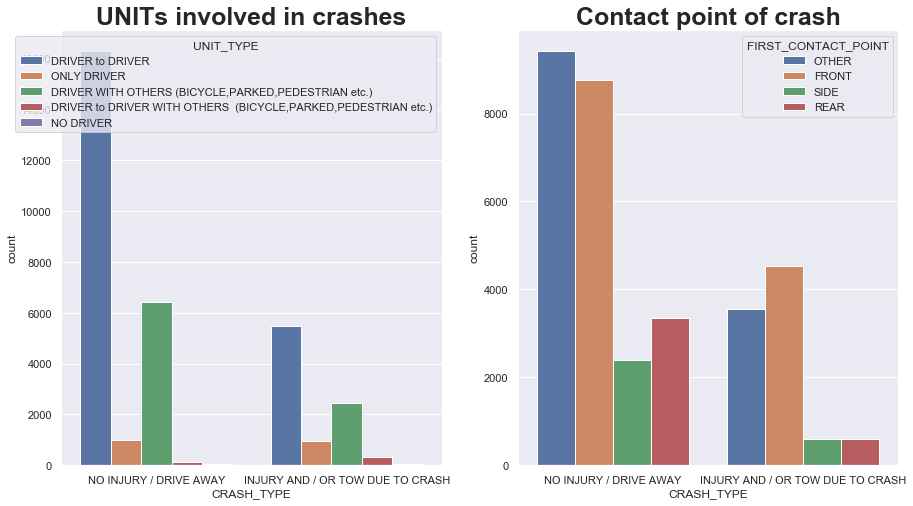

In [46]:
plt.figure(figsize=(15,8))

plt.subplot(1, 2, 1)
plt.xticks(rotation=0)
sns.countplot(x='CRASH_TYPE',data=df_new,hue='UNIT_TYPE')
plt.title("UNITs involved in crashes", fontsize=25, fontweight="bold")

plt.subplot(1, 2, 2)
plt.xticks(rotation=0)
sns.countplot(x='CRASH_TYPE',data=df_new,hue='FIRST_CONTACT_POINT')
plt.title("Contact point of crash", fontsize=25, fontweight="bold")

In [47]:
# merging same type of Maneuver in one
df_new["MANEUVER"].fillna("UNKNOWN/NA",inplace=True)
df_new["MANEUVER"] = df_new["MANEUVER"].apply(lambda x: "TURN" if "TURN" in x else("LANE" if any(s in x for s in ["LANE","OVER","ENTER"]) else x))
df_new["MANEUVER"] = df_new["MANEUVER"].apply(lambda x: "OTHER" if all(s not in x for s in ["AHEAD","TURN","UNKNOWN","LANE","BACKING"]) else x)

# converting VEHICLE_YEAR into new category of OLD or NEW
df_new["VEHICLE_YEAR"]= df_new["VEHICLE_YEAR"].apply(lambda x: "OLD (<2010)" if x <2010 else "NEW")

# converting POSTED_SPEED_LIMIT into new category of LOW SPEED or HIGH SPEED
df_new["POSTED_SPEED_LIMIT"]=df_new["POSTED_SPEED_LIMIT"].apply(lambda x: "LOW_SPEED (<=30)" if x<=30 else "HIGH_SPEED")

Text(0.5, 1.0, 'Car speed in FATAL Crash')

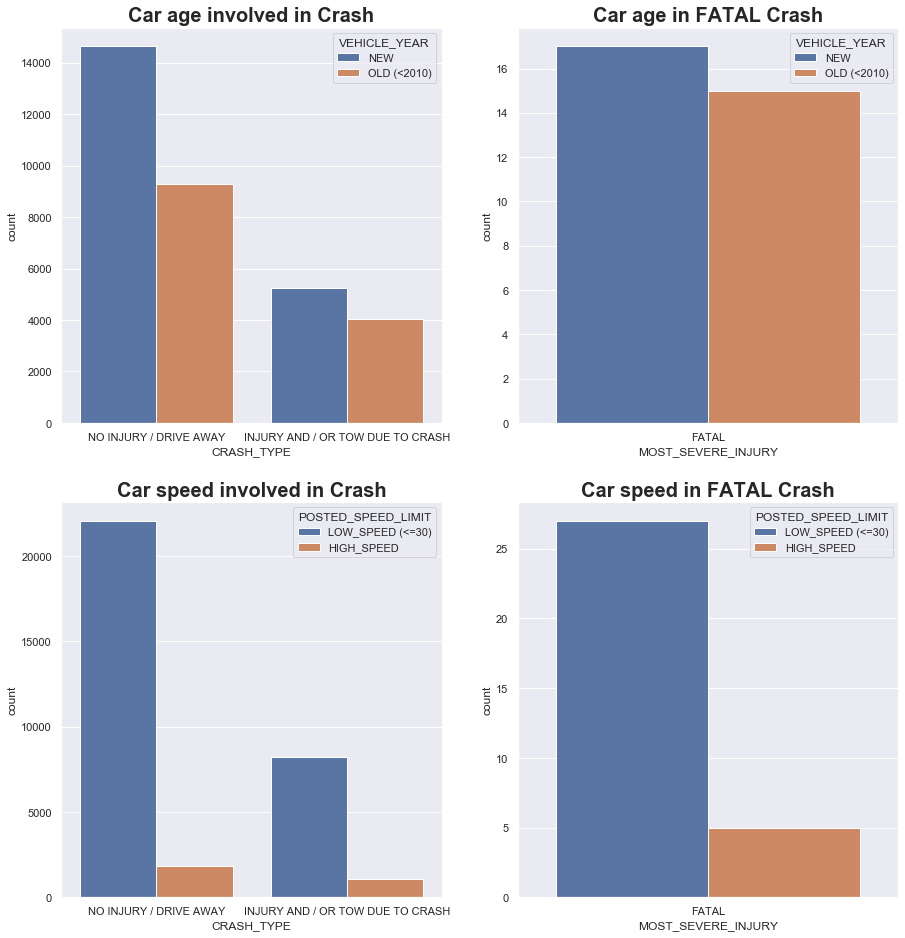

In [48]:
#plotting graph
plt.figure(figsize=(15,16))
plt.subplot(2, 2, 1)
plt.xticks(rotation=0)
sns.countplot(x='CRASH_TYPE',data=df_new,hue='VEHICLE_YEAR')
plt.title("Car age involved in Crash", fontsize=20, fontweight="bold")

plt.subplot(2, 2, 2)
plt.xticks(rotation=0)
sns.countplot(x='MOST_SEVERE_INJURY',data=df_new[df_new["MOST_SEVERE_INJURY"]=="FATAL"],hue='VEHICLE_YEAR',hue_order= ['NEW', 'OLD (<2010)'])
plt.title("Car age in FATAL Crash", fontsize=20, fontweight="bold")

plt.subplot(2, 2, 3)
plt.xticks(rotation=0)
sns.countplot(x='CRASH_TYPE',data=df_new,hue='POSTED_SPEED_LIMIT')
plt.title("Car speed involved in Crash", fontsize=20, fontweight="bold")

plt.subplot(2, 2, 4)
plt.xticks(rotation=0)
sns.countplot(x='MOST_SEVERE_INJURY',data=df_new[df_new["MOST_SEVERE_INJURY"]=="FATAL"],hue='POSTED_SPEED_LIMIT')
plt.title("Car speed in FATAL Crash", fontsize=20, fontweight="bold")

In [49]:
df_people  = pd.read_csv("data/people.sample.csv")
# grouping the SAFETY_EQUIPMENT used as SAFE and UNSAFE
def equip_used(x):
    if ("USED" in x) or ("HELMET" in x) or ("NONE PRESENT" in x):
        if any(s in x for s in ["NOT","IMPROPER","NONE PRESENT"]):
            return "DID NOT USE SAFETY EQUIP"
        else:
            return "USED SAFETY EQUIP"
    else:
        return x

# replacing NA with USAGE UNKNOWN before grouping them
df_people["SAFETY_EQUIPMENT"].fillna("USAGE UNKNOWN", inplace=True)
df_people["SAFETY_EQUIPMENT"]= df_people["SAFETY_EQUIPMENT"].apply(lambda x: equip_used(x))


# grouping the AIRBAG_DEPLOYED used as DEPLOYED and NOT DEPLOYED
def airbag(x):
    if ("DEPLOY" in x) and ("UNKNOWN" not in x):
        if "NOT" in x:
            return "NOT DEPLOYED"
        else:
            return "DEPLOYED"
    else:
        return x
 
# replacing NA with DEPLOYMENT UNKNOWN before grouping them
df_people["AIRBAG_DEPLOYED"].fillna("DEPLOYMENT UNKNOWN", inplace=True)
df_people["AIRBAG_DEPLOYED"]= df_people["AIRBAG_DEPLOYED"].apply(lambda x: airbag(x))

Text(0.5, 1.0, 'Drivers in FATAL Crash')

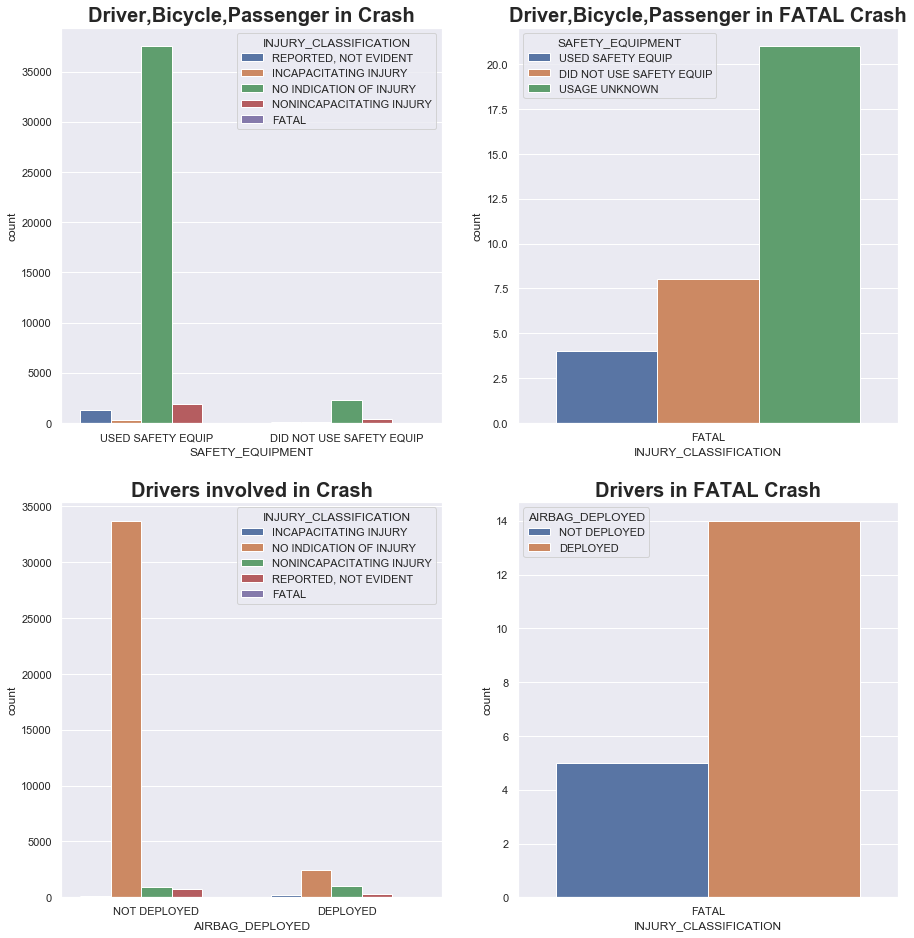

In [50]:
plt.figure(figsize=(15,16))

plt.subplot(2, 2, 1)
plt.xticks(rotation=0)
df_filter_people = df_people[(df_people["PERSON_TYPE"].isin(["DRIVER","BICYCLE","PASSENGER"])) & 
                             (df_people["SAFETY_EQUIPMENT"].isin(["USED SAFETY EQUIP","DID NOT USE SAFETY EQUIP"]))]
sns.countplot(x='SAFETY_EQUIPMENT',hue='INJURY_CLASSIFICATION',data=df_filter_people)
plt.title("Driver,Bicycle,Passenger in Crash", fontsize=20, fontweight="bold")

plt.subplot(2, 2, 2)
plt.xticks(rotation=0)
df_filter_people = df_people[(df_people["PERSON_TYPE"].isin(["DRIVER","BICYCLE","PASSENGER"])) & 
                             (df_people["INJURY_CLASSIFICATION"].isin(['FATAL']))]
sns.countplot(x='INJURY_CLASSIFICATION',hue='SAFETY_EQUIPMENT',data=df_filter_people)
plt.title("Driver,Bicycle,Passenger in FATAL Crash", fontsize=20, fontweight="bold")

plt.subplot(2, 2, 3)
plt.xticks(rotation=0)
df_filter_people = df_people[(df_people["PERSON_TYPE"].isin(["DRIVER"])) &
                            (df_people["AIRBAG_DEPLOYED"].isin(["DEPLOYED","NOT DEPLOYED"]))]
sns.countplot(x='AIRBAG_DEPLOYED',hue='INJURY_CLASSIFICATION',data=df_filter_people)
plt.title("Drivers involved in Crash", fontsize=20, fontweight="bold")

plt.subplot(2, 2, 4)
plt.xticks(rotation=0)
df_filter_people = df_people[(df_people["PERSON_TYPE"].isin(["DRIVER"])) &
                            (df_people["AIRBAG_DEPLOYED"].isin(["DEPLOYED","NOT DEPLOYED"])) & 
                             (df_people["INJURY_CLASSIFICATION"].isin(['FATAL']))]
sns.countplot(x='INJURY_CLASSIFICATION',hue='AIRBAG_DEPLOYED',data=df_filter_people)
plt.title("Drivers in FATAL Crash", fontsize=20, fontweight="bold")

In [51]:
# Appx ~65 seconds
elapsed = timeit.default_timer() - start_time
print('Runtime of the script is', round(elapsed, 2), 'seconds.')

Runtime of the script is 116.5 seconds.


<a id='First summary'></a>

## First Summary

*[Back to Top](#top)*

According to Business Understanding & EDA

Potential target features are
- `crashes.DAMAGE`
- `crashes.INJURIES_TOTAL`
- `crashes.INJURIES_FATAL`
- `people.INJURY_CLASSIFICATION`
---

Influential features are
- `crashes.POSTED_SPEED_LIMIT`
- `crashes.CRASH_TYPE`
- `crashes.STREET_NAME`
- `vehicles.UNIT_TYPE`
- `vehicles.VEHICLE_TYPE`
- `vehicles.VEHICLE_DEFECT`
- `vehicles.MANEUVER`
- `people.SAFETY_EQUIPMENT`
- `people.AIRBAG_DEPLOYED`
---

Potential insight features are
- `crashes.PRIM_CONTRIBUTORY_CAUSE`
- `crashes.SEC_CONTRIBUTORY_CAUSE`
- `crashes.POSTED_SPEED_LIMIT`
- `crashes.CRASH_TYPE`
- `crashes.STREET_NAME`
- `crashes.LIGHTING_CONDITION`
- `crashes.FIRST_CRASH_TYPE`
- `people.DRIVER_ACTION`
- `people.DRIVER_LICENSE_CLASS`
- `people.PERSON_TYPE`
- `people.PHYSICAL_CONDITION`
- `vehicles.UNIT_TYPE`
- `vehicles.VEHICLE_TYPE`
- `vehicles.VEHICLE_DEFECT`
- `vehicles.MANEUVER`

---